# √âtape 1 ‚Äî D√©finir les constantes ¬´ overview ¬ª (traduction FR)

**Objectif.** Centraliser les param√®tres globaux de l‚Äô√©tude (croissance, main-d‚Äô≈ìuvre, actualisation, horizon) dans un fichier unique `overview.py`.
**Remarques cl√©s.**

* Les **taux** sont en fraction (ex. `0.02` = 2 %).
* Les **heures suppl√©mentaires** se paient √† **1,5√ó** le salaire de base. Comme le ¬´ 1,0√ó ¬ª est d√©j√† compt√© dans les heures normales, on ajoute seulement la **majoration** de `0,5√ó` pour les heures sup (d‚Äôo√π `facteur_majoration_heures_sup = 0.5`).
* L‚Äô√©nonc√© demande de comparer les options sur un **horizon de 5 ans** et d‚Äô√©valuer la **VAN** pour choisir entre agrandir le stade existant ou en construire un nouveau. 


In [126]:
import pandas as pd

# 1. Forcer pandas √† ne jamais afficher en notation scientifique
pd.options.display.float_format = '{:,.2f}'.format

# 2. Ajouter s√©parateurs d'espaces pour les grands nombres (style fran√ßais)
pd.options.display.float_format = lambda x: f"{x:,.2f}".replace(",", " ")


## √âtape 2 ‚Äî Donn√©es Main-d'≈ìuvre

Nous importons la feuille *Main-d'≈ìuvre* du fichier Excel :  
- On saute les 3 premi√®res lignes d‚Äôinstructions.  
- On conserve **toutes les colonnes** (toutes sont utiles pour l‚Äôanalyse).  
- On ignore la premi√®re colonne (inutile).  
- On ajoute une colonne calcul√©e : **Salaire annuel (ann√©e 1)** en tenant compte :
  - des heures normales (heures moyennes √ó salaire horaire √ó 12),
  - des heures suppl√©mentaires : une heure suppl√©mentaire est pay√©e **1,5 √ó le salaire horaire**.  
    Comme les **1,0 √ó** sont d√©j√† compt√©s dans les heures normales, on ajoute seulement **+0,5 √ó salaire horaire √ó heures sup √ó 12**.


In [127]:
import pandas as pd
import sys, os
sys.path.insert(0, os.path.abspath(".."))

from utils.constants import VUEDENSEMBLE

# Charger le fichier Excel (adapter le chemin si besoin)
fichier_excel = "../data/Toronto Sports Entertainment_Sept 2025_FR.xlsx"

# Lire la feuille "Main-d'oeuvre" en sautant les 3 premi√®res lignes
df_main = pd.read_excel(fichier_excel, sheet_name="Informations - main d'oeuvre", skiprows=3)
df_main = df_main.iloc[:, 1:]  # Supprimer la premi√®re colonne vide
df_main["Option de projet d‚Äôinfrastructure"] = df_main["Option de projet d‚Äôinfrastructure"].replace({
    "Agrandir le TO Field": "Agrandissement du TO Field",
    "Construire un nouveau stade": "Construction d‚Äôun nouveau stade"
})

# Calcul du salaire annuel de la premi√®re ann√©e
heures_base_mois = VUEDENSEMBLE["heures_moyennes_par_mois"]
facteur_sup = VUEDENSEMBLE["facteur_majoration_heures_sup"]

df_main["Salaire annuel (ann√©e 1)"] = (
    (heures_base_mois * df_main["Salaire horaire ($)"] * 12)
    + (df_main["Heures suppl√©mentaires/mois"] * df_main["Salaire horaire ($)"] * (1 + facteur_sup) * 12)
)

print("Constantes utilis√©es :")
print(f"Heures moyennes par mois = {heures_base_mois}")
print(f"Facteur de majoration heures suppl√©mentaires = {facteur_sup}")

df_main.head()


Constantes utilis√©es :
Heures moyennes par mois = 130
Facteur de majoration heures suppl√©mentaires = 0.5


Option de projet d‚Äôinfrastructure                            R√¥le  \
0   Construction d‚Äôun nouveau stade                       Ing√©nieur   
1        Agrandissement du TO Field          Gestionnaire de projet   
2   Construction d‚Äôun nouveau stade  Travailleur de la construction   
3        Agrandissement du TO Field                     √âlectricien   
4        Agrandissement du TO Field  Travailleur de la construction   

  Niveau d'√©ducation  Salaire horaire ($)  Heures suppl√©mentaires/mois  \
0           Ma√Ætrise                   40                            1   
1           Doctorat                   84                            6   
2           Ma√Ætrise                   63                            2   
3           Ma√Ætrise                   81                            8   
4   √âcole secondaire                   46                           39   

   Salaire annuel (ann√©e 1)  
0                 63 120.00  
1                140 112.00  
2                100 548.00  
3                138 024.00  
4                104 052.00

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# S'assurer des bons types num√©riques
cols_num = ["Salaire horaire ($)", "Heures suppl√©mentaires/mois"]
cols_num += [c for c in df_main.columns if c.startswith("Salaire annuel (ann√©e ")]
df_main[cols_num] = df_main[cols_num].apply(pd.to_numeric, errors="coerce")

# Formateur "milliers avec espaces" pour les axes
def fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
formatter = FuncFormatter(fmt_milliers)

# Petite palette de projets (ordre stable)
projets = list(df_main["Option de projet d‚Äôinfrastructure"].dropna().unique())


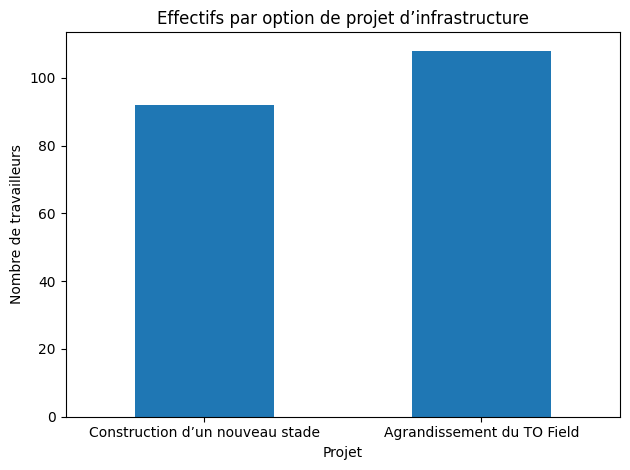

In [167]:
vc = df_main["Option de projet d‚Äôinfrastructure"].value_counts().reindex(projets)

plt.figure()
vc.plot(kind="bar")
plt.title("Effectifs par option de projet d‚Äôinfrastructure")
plt.xlabel("Projet")
plt.ylabel("Nombre de travailleurs")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

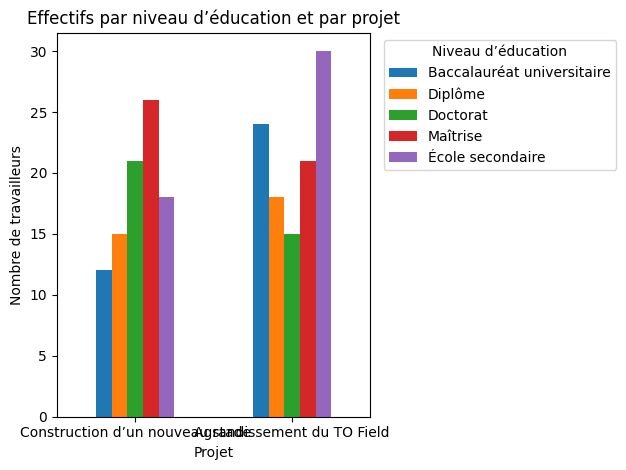

In [168]:
edu = (
    df_main
    .groupby(["Option de projet d‚Äôinfrastructure", "Niveau d'√©ducation"])
    .size()
    .unstack(fill_value=0)
    .reindex(projets)
)

plt.figure()
edu.plot(kind="bar")
plt.title("Effectifs par niveau d‚Äô√©ducation et par projet")
plt.xlabel("Projet")
plt.ylabel("Nombre de travailleurs")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks(rotation=0)
plt.legend(title="Niveau d‚Äô√©ducation", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


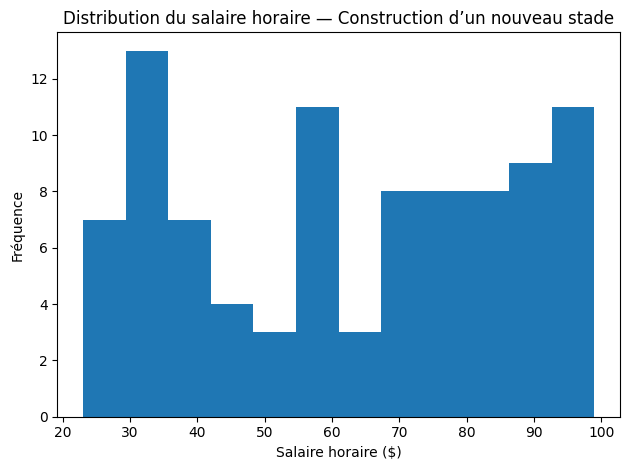

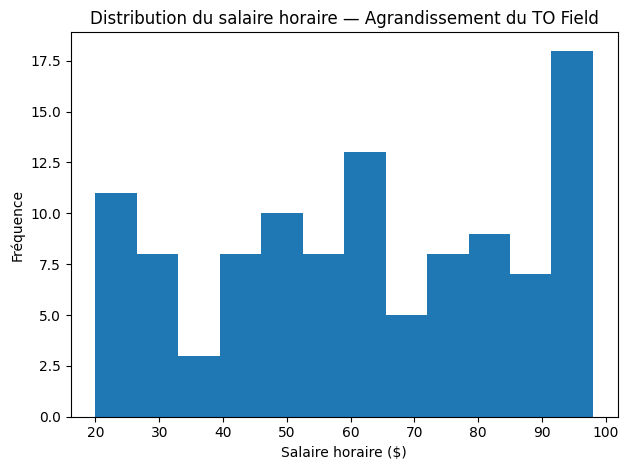

In [169]:
for p in projets:
    data = df_main.loc[df_main["Option de projet d‚Äôinfrastructure"] == p, "Salaire horaire ($)"].dropna()
    plt.figure()
    plt.hist(data, bins=12)
    plt.title(f"Distribution du salaire horaire ‚Äî {p}")
    plt.xlabel("Salaire horaire ($)")
    plt.ylabel("Fr√©quence")
    plt.tight_layout()
    plt.show()


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\1280334285.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=projets, showfliers=True)


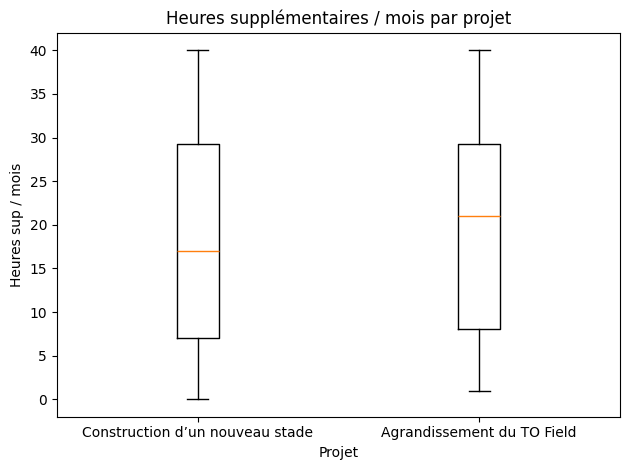

In [170]:
data_box = [df_main.loc[df_main["Option de projet d‚Äôinfrastructure"] == p, "Heures suppl√©mentaires/mois"].dropna() for p in projets]

plt.figure()
plt.boxplot(data_box, labels=projets, showfliers=True)
plt.title("Heures suppl√©mentaires / mois par projet")
plt.xlabel("Projet")
plt.ylabel("Heures sup / mois")
plt.tight_layout()
plt.show()


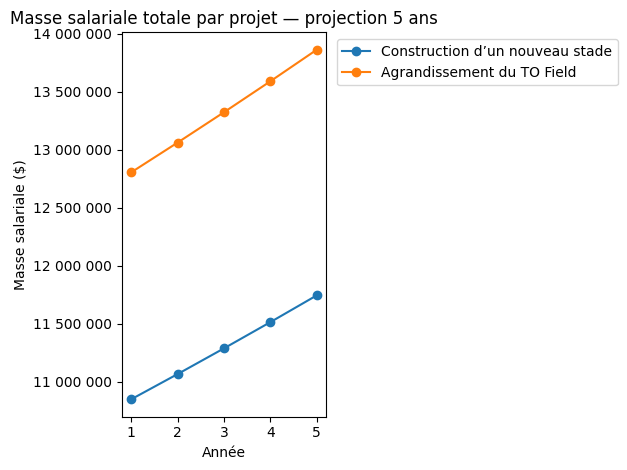

In [171]:
# Colonnes des salaires annuels (ann√©e 1..5)
cols_sal = [c for c in df_main.columns if c.startswith("Salaire annuel (ann√©e ")]
cols_sal = sorted(cols_sal, key=lambda x: int(x.split("ann√©e ")[1].rstrip(")")))

# Agr√©gation par projet
masse = (
    df_main.groupby("Option de projet d‚Äôinfrastructure")[cols_sal]
    .sum(numeric_only=True)
    .reindex(projets)
)

# Conversion en format long pour tracer des courbes
masse_long = (
    masse
    .reset_index()
    .melt(id_vars="Option de projet d‚Äôinfrastructure", var_name="Ann√©e", value_name="Masse salariale")
)
# Nettoyage des labels d'ann√©e -> 1..5
masse_long["Ann√©e_num"] = masse_long["Ann√©e"].str.extract(r"(\d+)").astype(int)

plt.figure()
for p in projets:
    sub = masse_long[masse_long["Option de projet d‚Äôinfrastructure"] == p].sort_values("Ann√©e_num")
    plt.plot(sub["Ann√©e_num"], sub["Masse salariale"], marker="o", label=p)

plt.title("Masse salariale totale par projet ‚Äî projection 5 ans")
plt.xlabel("Ann√©e")
plt.ylabel("Masse salariale ($)")
plt.gca().yaxis.set_major_formatter(formatter)
plt.xticks([1,2,3,4,5])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


## √âtape 3 ‚Äî Projection des salaires sur 5 ans

√Ä partir du **salaire annuel (ann√©e 1)** calcul√© √† l‚Äô√©tape 2 :  
- Nous appliquons le **taux de croissance des co√ªts** d√©fini dans `constants.py`.  
- Pour chaque r√¥le, nous g√©n√©rons 4 nouvelles colonnes : `Salaire annuel (ann√©e 2)`, ..., `Salaire annuel (ann√©e 5)`.  
- Cela permet d‚Äôobtenir le **co√ªt de main-d‚Äô≈ìuvre projet√© sur 5 ans**.


In [128]:
# R√©cup√©ration du taux de croissance des co√ªts
taux_croissance = VUEDENSEMBLE["taux_croissance_couts"]

# Cr√©ation des colonnes pour les ann√©es 2 √† 5
for annee in range(2, VUEDENSEMBLE["duree_analyse_ans"] + 1):
    col_prec = f"Salaire annuel (ann√©e {annee-1})"
    col_nouv = f"Salaire annuel (ann√©e {annee})"
    df_main[col_nouv] = df_main[col_prec] * (1 + taux_croissance)

print(f"Taux de croissance des co√ªts = {taux_croissance}")

# Aper√ßu des 5 premi√®res lignes
df_main.head()


Taux de croissance des co√ªts = 0.02


Option de projet d‚Äôinfrastructure                            R√¥le  \
0   Construction d‚Äôun nouveau stade                       Ing√©nieur   
1        Agrandissement du TO Field          Gestionnaire de projet   
2   Construction d‚Äôun nouveau stade  Travailleur de la construction   
3        Agrandissement du TO Field                     √âlectricien   
4        Agrandissement du TO Field  Travailleur de la construction   

  Niveau d'√©ducation  Salaire horaire ($)  Heures suppl√©mentaires/mois  \
0           Ma√Ætrise                   40                            1   
1           Doctorat                   84                            6   
2           Ma√Ætrise                   63                            2   
3           Ma√Ætrise                   81                            8   
4   √âcole secondaire                   46                           39   

   Salaire annuel (ann√©e 1)  Salaire annuel (ann√©e 2)  \
0                 63 120.00                 64 382.40   
1                140 112.00                142 914.24   
2                100 548.00                102 558.96   
3                138 024.00                140 784.48   
4                104 052.00                106 133.04   

   Salaire annuel (ann√©e 3)  Salaire annuel (ann√©e 4)  \
0                 65 670.05                 66 983.45   
1                145 772.52                148 687.98   
2                104 610.14                106 702.34   
3                143 600.17                146 472.17   
4                108 255.70                110 420.81   

   Salaire annuel (ann√©e 5)  
0                 68 323.12  
1                151 661.73  
2                108 836.39  
3                149 401.62  
4                112 629.23

## √âtape 4 ‚Äî Agr√©gation des salaires par projet

Nous regroupons les donn√©es par **option de projet d‚Äôinfrastructure** :  
- Pour chaque projet (Construire un nouveau stade, Agrandir le TO Field),  
  - nous additionnons les salaires par ann√©e (ann√©e 1 √† 5),  
  - nous comptons le nombre total de travailleurs associ√©s.  

Cela permet de comparer directement l‚Äô√©volution des co√ªts de main-d‚Äô≈ìuvre pour les deux projets sur 5 ans.


In [129]:
# Agr√©ger par option de projet d'infrastructure
df_salaire_projet = df_main.groupby("Option de projet d‚Äôinfrastructure").agg(
    {
        "Salaire annuel (ann√©e 1)": "sum",
        "Salaire annuel (ann√©e 2)": "sum",
        "Salaire annuel (ann√©e 3)": "sum",
        "Salaire annuel (ann√©e 4)": "sum",
        "Salaire annuel (ann√©e 5)": "sum",
        "R√¥le": "count"  # nombre de travailleurs
    }
)

# Renommer la colonne "R√¥le" pour plus de clart√©
df_salaire_projet = df_salaire_projet.rename(columns={"R√¥le": "Nombre de travailleurs"})

df_salaire_projet


Salaire annuel (ann√©e 1)  \
Option de projet d‚Äôinfrastructure                             
Agrandissement du TO Field                    12 804 216.00   
Construction d‚Äôun nouveau stade               10 848 822.00   

                                   Salaire annuel (ann√©e 2)  \
Option de projet d‚Äôinfrastructure                             
Agrandissement du TO Field                    13 060 300.32   
Construction d‚Äôun nouveau stade               11 065 798.44   

                                   Salaire annuel (ann√©e 3)  \
Option de projet d‚Äôinfrastructure                             
Agrandissement du TO Field                    13 321 506.33   
Construction d‚Äôun nouveau stade               11 287 114.41   

                                   Salaire annuel (ann√©e 4)  \
Option de projet d‚Äôinfrastructure                             
Agrandissement du TO Field                    13 587 936.45   
Construction d‚Äôun nouveau stade               11 512 856.70   

                                   Salaire annuel (ann√©e 5)  \
Option de projet d‚Äôinfrastructure                             
Agrandissement du TO Field                    13 859 695.18   
Construction d‚Äôun nouveau stade               11 743 113.83   

                                   Nombre de travailleurs  
Option de projet d‚Äôinfrastructure                          
Agrandissement du TO Field                            108  
Construction d‚Äôun nouveau stade                        92

In [172]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assure les bons types
cols_annees = [f"Salaire annuel (ann√©e {i})" for i in range(1, 6)]
df_salaire_projet[cols_annees + ["Nombre de travailleurs"]] = (
    df_salaire_projet[cols_annees + ["Nombre de travailleurs"]]
    .apply(pd.to_numeric, errors="coerce")
)

# Formateur "milliers avec espaces" pour les axes
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

projets = df_salaire_projet.index.tolist()


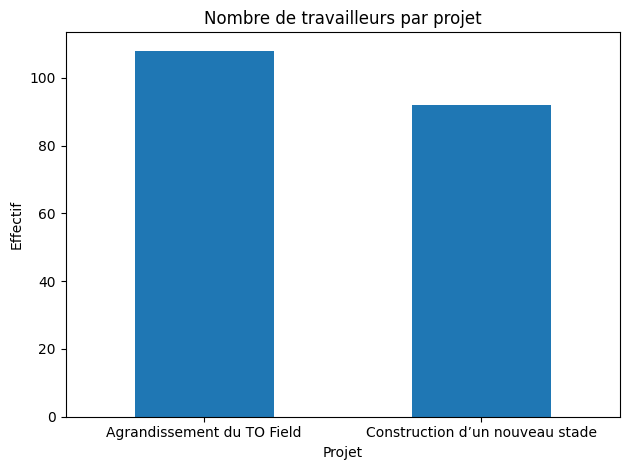

In [173]:
plt.figure()
df_salaire_projet["Nombre de travailleurs"].reindex(projets).plot(kind="bar")
plt.title("Nombre de travailleurs par projet")
plt.xlabel("Projet")
plt.ylabel("Effectif")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


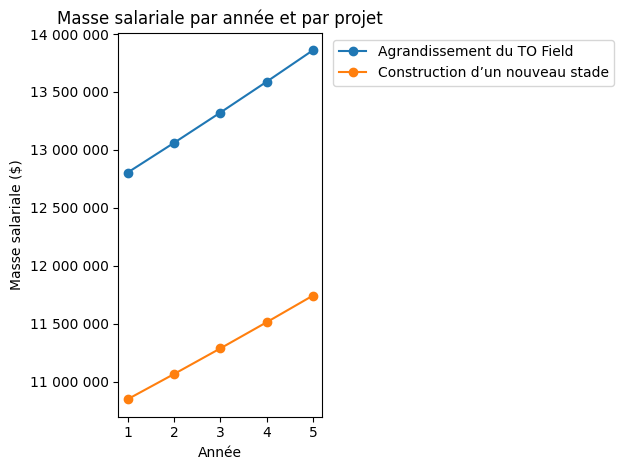

In [174]:
# Passage en long pour tracer ann√©e 1‚Üí5
tmp = (
    df_salaire_projet[cols_annees]
    .assign(Projet=df_salaire_projet.index)
    .melt(id_vars="Projet", var_name="Ann√©e", value_name="Masse")
)
tmp["Ann√©e_num"] = tmp["Ann√©e"].str.extract(r"(\d+)").astype(int)

plt.figure()
for p in projets:
    sub = tmp[tmp["Projet"] == p].sort_values("Ann√©e_num")
    plt.plot(sub["Ann√©e_num"], sub["Masse"], marker="o", label=p)

plt.title("Masse salariale par ann√©e et par projet")
plt.xlabel("Ann√©e")
plt.ylabel("Masse salariale ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks([1,2,3,4,5])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()


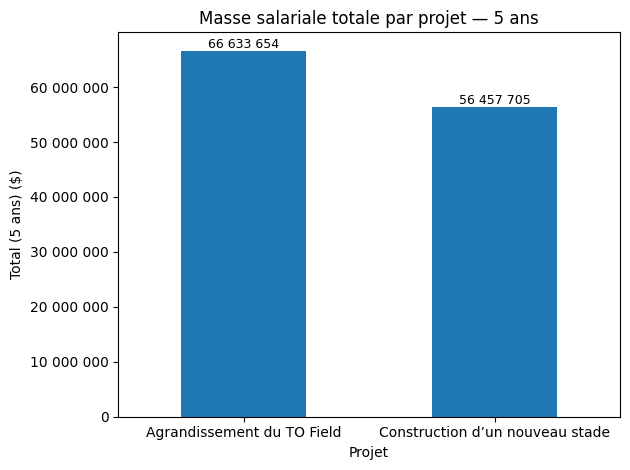

In [175]:
df_plot = df_salaire_projet.copy()
df_plot["Total (5 ans)"] = df_plot[cols_annees].sum(axis=1)

plt.figure()
ax = df_plot["Total (5 ans)"].reindex(projets).plot(kind="bar")
plt.title("Masse salariale totale par projet ‚Äî 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# petites √©tiquettes au-dessus des barres
for i, v in enumerate(df_plot["Total (5 ans)"].reindex(projets).values):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


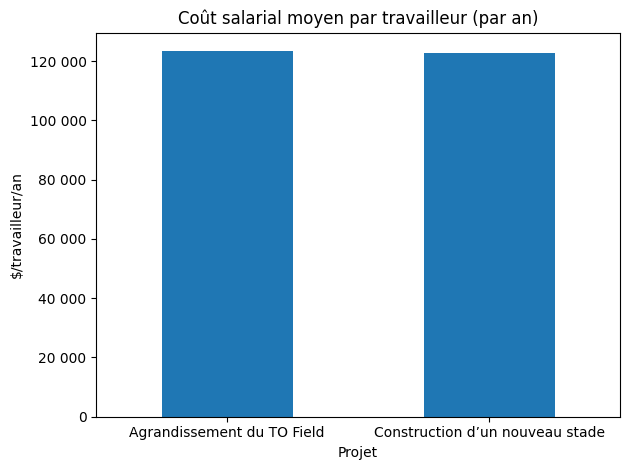

In [176]:
df_plot = df_salaire_projet.copy()
df_plot["Total (5 ans)"] = df_plot[cols_annees].sum(axis=1)
df_plot["Moyenne annuelle par travailleur"] = df_plot["Total (5 ans)"] / 5 / df_plot["Nombre de travailleurs"]

plt.figure()
df_plot["Moyenne annuelle par travailleur"].reindex(projets).plot(kind="bar")
plt.title("Co√ªt salarial moyen par travailleur (par an)")
plt.xlabel("Projet")
plt.ylabel("$/travailleur/an")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## üìí Conclusion √âtape 4 ‚Äî Main-d‚Äô≈ìuvre (salaires)

Sur 5 ans :

* **Agrandissement du TO Field** : environ **13,8 M$ par an** de salaires en fin de p√©riode, pour **108 travailleurs**.
* **Construction d‚Äôun nouveau stade** : environ **11,7 M$ par an** en fin de p√©riode, pour **92 travailleurs**.

üëâ Conclusion : l‚Äôagrandissement mobilise **davantage de main-d‚Äô≈ìuvre (+16 personnes)** et co√ªte plus cher en salaires, mais le nouveau stade a une masse salariale plus contenue malgr√© des salaires unitaires plus √©lev√©s. Cela peut se traduire par une structure plus l√©g√®re en exploitation.

## √âtape 5 ‚Äî Co√ªts de construction

Nous importons la feuille *Co√ªts de construction* du fichier Excel :  
- On saute les 3 premi√®res lignes d‚Äôinstructions.  
- On conserve toutes les colonnes.  
- Pour chaque option de projet (Construire un nouveau stade, Agrandir le TO Field),  
  - nous identifions les **co√ªts de construction** initiaux,  
  - nous pr√©parons une projection sur 5 ans (si applicable, en appliquant le taux de croissance des co√ªts).  

Cette √©tape est cruciale, car les co√ªts de construction repr√©sentent une **d√©pense majeure initiale** qui impacte directement la VAN.  
Ces chiffres, combin√©s avec les co√ªts de main-d‚Äô≈ìuvre et les revenus futurs, permettront d‚Äô√©valuer la rentabilit√© relative des deux options.


In [130]:
# Lecture de la feuille "Construction" en sautant les 3 premi√®res lignes
df_construction = pd.read_excel(fichier_excel, sheet_name="Co√ªts de construction", skiprows=3)
df_construction = df_construction.iloc[:, 1:]  # Supprimer la premi√®re colonne vide

# Conversion en float pour forcer l'affichage avec s√©parateurs d'espaces
df_construction = df_construction.astype(float, errors="ignore")

# Aper√ßu pour v√©rifier les colonnes
print("Aper√ßu des co√ªts de construction :")
display(df_construction.head())

Aper√ßu des co√ªts de construction :


Option de projet d‚Äôinfrastructure  Co√ªt d‚Äôachat du terrain  \
0        Agrandissement du TO Field            25 000 000.00   
1   Construction d‚Äôun nouveau stade           343 000 000.00   

   Co√ªts de permis et d‚Äôinspection du site  Co√ªts de pr√©paration du site  \
0                                29 000.00                    131 000.00   
1                                69 000.00                    428 000.00   

   Co√ªts annuels d‚Äôentretien  Co√ªts annuels de location d‚Äô√©quipement  \
0                 500 000.00                               76 000.00   
1                 630 000.00                              103 000.00   

   Co√ªts mensuels de fournitures et mat√©riaux  \
0                                   55 000.00   
1                                  119 000.00   

   Co√ªts mensuels des services publics  \
0                            32 000.00   
1                            32 000.00   

   Part mensuelle des revenus partag√©s avec les sponsors  
0                                          20 000.00      
1                                          10 000.00

## √âtape 5.1 ‚Äî Analyse et insights des co√ªts de construction

√Ä partir du tableau projet√© (Ann√©e 0 ‚Üí Ann√©e 5), nous ajoutons deux enrichissements :  

1. **Total (0-5 ans)** : somme des co√ªts sur toute la p√©riode d‚Äôanalyse.  
2. **% du co√ªt initial sur le total** : mesure du poids des co√ªts upfront dans le projet.  

### Conclusions possibles
- Un pourcentage √©lev√© signifie un projet tr√®s **capitalistique** avec un risque initial important.  
- Un pourcentage plus faible signifie que le projet est **plus √©tal√© dans le temps**, mais avec des charges r√©currentes plus importantes.  
Ces diff√©rences structurent la mani√®re dont les projets impactent la tr√©sorerie et la prise de risque, et constituent des arguments dans le choix final.


In [131]:
taux_croissance = VUEDENSEMBLE["taux_croissance_couts"]

# Colonnes
col_uniques = ["Co√ªt d‚Äôachat du terrain", "Co√ªts de permis et d‚Äôinspection du site", "Co√ªts de pr√©paration du site"]
col_annuels = ["Co√ªts annuels d‚Äôentretien", "Co√ªts annuels de location d‚Äô√©quipement"]
col_mensuels = ["Co√ªts mensuels de fournitures et mat√©riaux", "Co√ªts mensuels des services publics", "Part mensuelle des revenus partag√©s avec les sponsors"]

# DataFrame de projection avec m√™me index et colonnes claires
df_construction_proj = pd.DataFrame(index=df_construction["Option de projet d‚Äôinfrastructure"].values)

# Ann√©e 0 : seulement les co√ªts uniques
df_construction_proj["Ann√©e 0"] = df_construction[col_uniques].sum(axis=1).values

# Ann√©es 1 √† 5
for annee in range(1, VUEDENSEMBLE["duree_analyse_ans"] + 1):
    facteur = (1 + taux_croissance) ** (annee - 1)
    couts_annuels = df_construction[col_annuels].sum(axis=1).values * facteur
    couts_mensuels = df_construction[col_mensuels].sum(axis=1).values * 12 * facteur
    df_construction_proj[f"Ann√©e {annee}"] = couts_annuels + couts_mensuels

df_construction_proj["Total (0-5 ans)"] = df_construction_proj.sum(axis=1)
df_construction_proj["% co√ªt initial sur total"] = (
    df_construction_proj["Ann√©e 0"] / df_construction_proj["Total (0-5 ans)"] * 100
)
df_construction_proj = df_construction_proj.astype(float)
df_construction_proj


Ann√©e 0      Ann√©e 1      Ann√©e 2  \
Agrandissement du TO Field       25 160 000.00 1 860 000.00 1 897 200.00   
Construction d‚Äôun nouveau stade 343 497 000.00 2 665 000.00 2 718 300.00   

                                     Ann√©e 3      Ann√©e 4      Ann√©e 5  \
Agrandissement du TO Field      1 935 144.00 1 973 846.88 2 013 323.82   
Construction d‚Äôun nouveau stade 2 772 666.00 2 828 119.32 2 884 681.71   

                                 Total (0-5 ans)  % co√ªt initial sur total  
Agrandissement du TO Field         34 839 514.70                     72.22  
Construction d‚Äôun nouveau stade   357 365 767.03                     96.12

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Colonnes (m√™mes noms que ta feuille Excel)
col_uniques = [
    "Co√ªt d‚Äôachat du terrain",
    "Co√ªts de permis et d‚Äôinspection du site",
    "Co√ªts de pr√©paration du site",
]
col_annuels = [
    "Co√ªts annuels d‚Äôentretien",
    "Co√ªts annuels de location d‚Äô√©quipement",
]
col_mensuels = [
    "Co√ªts mensuels de fournitures et mat√©riaux",
    "Co√ªts mensuels des services publics",
    "Part mensuelle des revenus partag√©s avec les sponsors",
]

# Types num√©riques pour √©viter les surprises
for cols in [col_uniques, col_annuels, col_mensuels]:
    df_construction[cols] = df_construction[cols].apply(pd.to_numeric, errors="coerce")

# Formatter "milliers avec espaces"
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Ordre des projets (depuis la projection)
projets = df_construction_proj.index.tolist()

# R√©cup du taux de croissance (pour 5.5 si besoin)
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS
gc = PARAMS["taux_croissance_couts"]


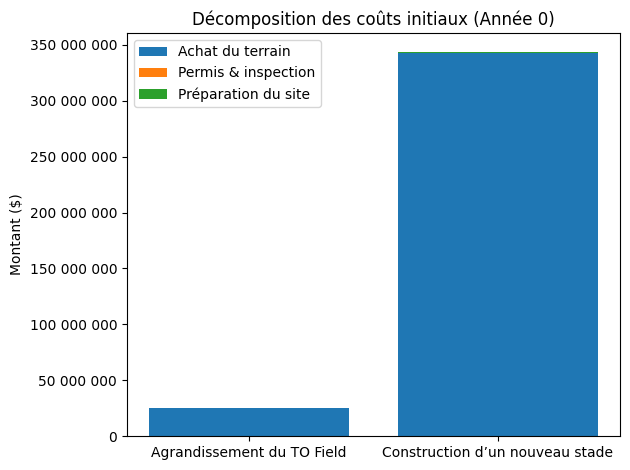

In [179]:
# Pr√©parer les segments par projet
x = np.arange(len(projets))
h_terrain = df_construction.set_index("Option de projet d‚Äôinfrastructure").loc[projets, "Co√ªt d‚Äôachat du terrain"].values
h_permis  = df_construction.set_index("Option de projet d‚Äôinfrastructure").loc[projets, "Co√ªts de permis et d‚Äôinspection du site"].values
h_prep    = df_construction.set_index("Option de projet d‚Äôinfrastructure").loc[projets, "Co√ªts de pr√©paration du site"].values

plt.figure()
b1 = plt.bar(x, h_terrain, label="Achat du terrain")
b2 = plt.bar(x, h_permis, bottom=h_terrain, label="Permis & inspection")
b3 = plt.bar(x, h_prep, bottom=h_terrain + h_permis, label="Pr√©paration du site")

plt.title("D√©composition des co√ªts initiaux (Ann√©e 0)")
plt.xticks(x, projets, rotation=0)
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.legend()
plt.tight_layout()
plt.show()


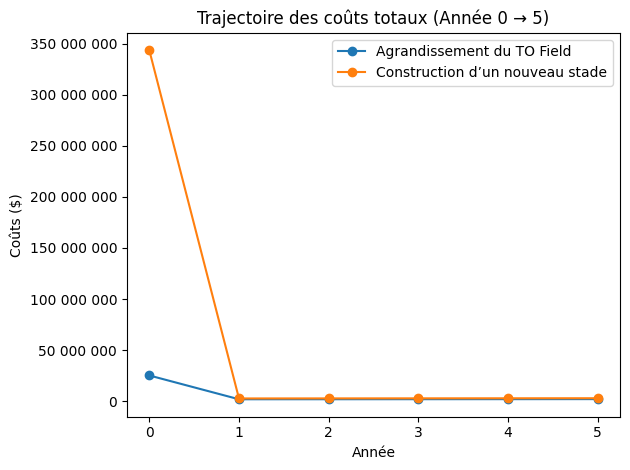

In [180]:
# Colonnes ann√©e
cols_annees = [c for c in df_construction_proj.columns if c.startswith("Ann√©e ")]
cols_annees_sorted = sorted(cols_annees, key=lambda s: int(s.split(" ")[1]))

plt.figure()
for p in projets:
    serie = df_construction_proj.loc[p, cols_annees_sorted]
    xs = [int(c.split(" ")[1]) for c in cols_annees_sorted]
    plt.plot(xs, serie.values, marker="o", label=p)

plt.title("Trajectoire des co√ªts totaux (Ann√©e 0 ‚Üí 5)")
plt.xlabel("Ann√©e")
plt.ylabel("Co√ªts ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks([0,1,2,3,4,5])
plt.legend()
plt.tight_layout()
plt.show()


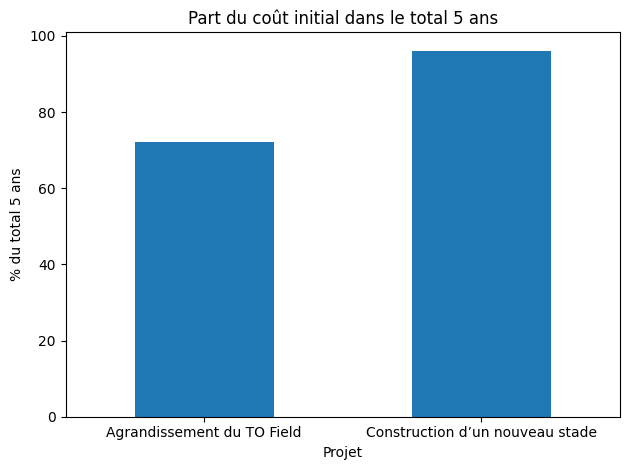

In [181]:
totaux_5ans = df_construction_proj[cols_annees_sorted].sum(axis=1)
part_init = (df_construction_proj["Ann√©e 0"] / totaux_5ans * 100).rename("Part initiale (%)")

plt.figure()
part_init.reindex(projets).plot(kind="bar")
plt.title("Part du co√ªt initial dans le total 5 ans")
plt.xlabel("Projet")
plt.ylabel("% du total 5 ans")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


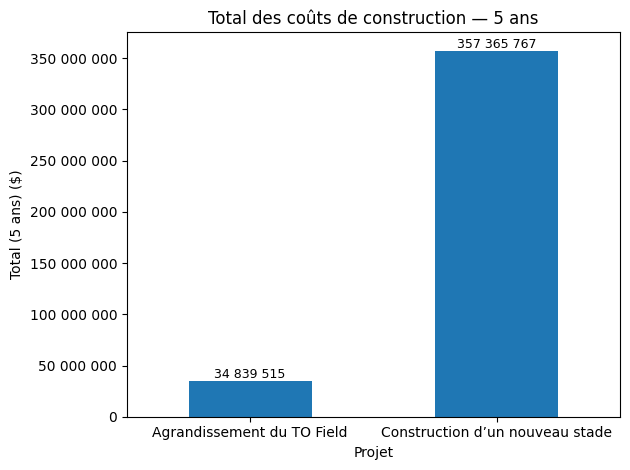

In [182]:
df_tot = pd.DataFrame({"Total (5 ans)": totaux_5ans}).reindex(projets)

plt.figure()
ax = df_tot["Total (5 ans)"].plot(kind="bar")
plt.title("Total des co√ªts de construction ‚Äî 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# labels au-dessus des barres
vals = df_tot["Total (5 ans)"].values
for i, v in enumerate(vals):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


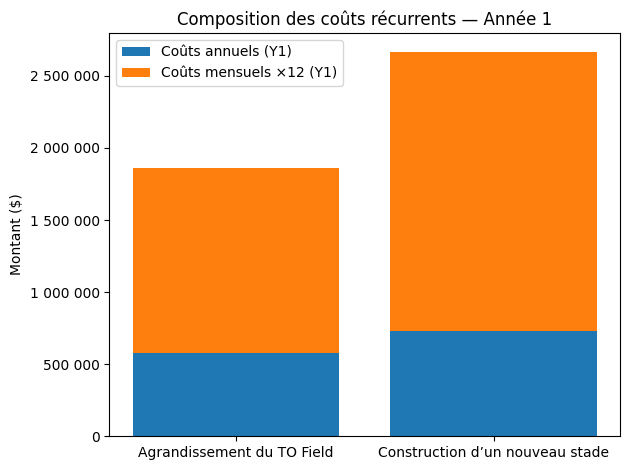

In [185]:
# Ann√©e 1 (facteur de croissance = 1)
annuels_y1  = df_construction.set_index("Option de projet d‚Äôinfrastructure")[col_annuels].sum(axis=1).loc[projets].astype(float).values
mensuels_y1 = (df_construction.set_index("Option de projet d‚Äôinfrastructure")[col_mensuels].sum(axis=1).loc[projets] * 12).astype(float).values

x = np.arange(len(projets))
plt.figure()
b1 = plt.bar(x, annuels_y1, label="Co√ªts annuels (Y1)")
b2 = plt.bar(x, mensuels_y1, bottom=annuels_y1, label="Co√ªts mensuels √ó12 (Y1)")

plt.title("Composition des co√ªts r√©currents ‚Äî Ann√©e 1")
plt.xticks(x, projets, rotation=0)
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.legend()
plt.tight_layout()
plt.show()


## üìí Conclusion √âtape 5.1 ‚Äî Co√ªts de construction

Sur la p√©riode de 5 ans (y compris les co√ªts initiaux) :

* **Agrandissement du TO Field** : environ **34,8 M$**, dont **72 % en co√ªt initial**.
* **Construction d‚Äôun nouveau stade** : environ **357 M$**, dont **96 % en co√ªt initial**.

üëâ Conclusion : le nouveau stade est **10 fois plus cher** et extr√™mement **capitalistique** (quasi tout pay√© d√®s l‚Äôan 0).
L‚Äôagrandissement, bien que beaucoup moins co√ªteux, conserve une part significative de frais r√©currents (entretien, services, fournitures) mais reste beaucoup plus l√©ger sur la tr√©sorerie initiale.

## √âtape 6 ‚Äî Lecture des revenus

Nous importons la feuille *Revenus* du fichier Excel :  
- On saute les 3 premi√®res lignes d‚Äôinstructions.  
- On supprime la premi√®re colonne inutile (colonne vide).  
- On affiche un aper√ßu des donn√©es brutes pour v√©rifier la structure et les colonnes disponibles.  

Cette √©tape sert uniquement √† **explorer et valider la table des revenus**, avant de passer √† l‚Äô√©tape 6.1 o√π nous ferons les projections et les analyses.


In [132]:
# Lecture de la feuille "Revenus" en sautant les 3 premi√®res lignes
df_revenus = pd.read_excel(fichier_excel, sheet_name="Revenus", skiprows=3)
df_revenus = df_revenus.iloc[:, 1:]  # Supprimer la premi√®re colonne vide

# Conversion en float pour forcer l'affichage avec s√©parateurs d'espaces
df_revenus = df_revenus.astype(float, errors="ignore")

# Aper√ßu des revenus
print("Aper√ßu des revenus :")
display(df_revenus.head())


Aper√ßu des revenus :


Option de projet d‚Äôinfrastructure  Revenus annuels de la billetterie ($)  \
0        Agrandissement du TO Field                           1 335 800.00   
1   Construction d‚Äôun nouveau stade                           2 070 110.00   

   Revenus annuels de sponsoring ($)  Revenus annuels des concessions ($)  \
0                       2 954 470.00                           420 660.00   
1                       2 822 390.00                           321 600.00   

   Ventes annuelles de marchandises ($)  
0                            166 110.00  
1                            798 950.00

## √âtape 6.1 ‚Äî Projection et analyse des revenus

√Ä partir des revenus de base (ann√©e 1), nous projetons les revenus sur 5 ans :  
- Une croissance annuelle de **15 %** est appliqu√©e.  
- On calcule le **Total cumul√© (5 ans)**.  
- On d√©compose les revenus par cat√©gorie pour analyser leur poids relatif (%).  

### Conclusions possibles
- Identifier quelle source de revenus est dominante (ex. sponsoring vs billetterie).  
- Comprendre si un projet est plus d√©pendant d‚Äôune source de revenus sp√©cifique (risque de concentration).  
- Comparer la dynamique de croissance entre les deux projets.


In [133]:
from IPython.display import display

# Colonnes des cat√©gories de revenus
colonnes_revenus = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)"
]

# Dictionnaire pour stocker les tableaux s√©par√©s
projets_revenus = {}

for idx, row in df_revenus.iterrows():
    projet = row["Option de projet d‚Äôinfrastructure"]
    data = {}

    # Projection ann√©e par ann√©e
    for col in colonnes_revenus:
        data[col] = [
            row[col] * (1 + taux_revenus) ** (annee - 1)
            for annee in range(1, VUEDENSEMBLE["duree_analyse_ans"] + 1)
        ]
    
    # Cr√©er un DataFrame avec Ann√©e 1 ‚Üí 5
    df_proj = pd.DataFrame(data, index=[f"Ann√©e {i}" for i in range(1, 6)])
    
    # Ajouter total cumul√© par cat√©gorie
    df_proj.loc["Total (5 ans)"] = df_proj.sum()
    
    # Ajouter % cat√©gorie (Ann√©e 1)
    part_totale = df_proj.loc["Ann√©e 1"].sum()
    for col in colonnes_revenus:
        df_proj[f"% {col} (Ann√©e 1)"] = (df_proj.loc["Ann√©e 1", col] / part_totale) * 100
    
    projets_revenus[projet] = df_proj

print("Agrandissement du TO Field")
display(projets_revenus["Agrandissement du TO Field"])

print("Construction d‚Äôun nouveau stade")
display(projets_revenus["Construction d‚Äôun nouveau stade"])



Agrandissement du TO Field


Revenus annuels de la billetterie ($)  \
Ann√©e 1                                 1 335 800.00   
Ann√©e 2                                 1 536 170.00   
Ann√©e 3                                 1 766 595.50   
Ann√©e 4                                 2 031 584.82   
Ann√©e 5                                 2 336 322.55   
Total (5 ans)                           9 006 472.87   

               Revenus annuels de sponsoring ($)  \
Ann√©e 1                             2 954 470.00   
Ann√©e 2                             3 397 640.50   
Ann√©e 3                             3 907 286.57   
Ann√©e 4                             4 493 379.56   
Ann√©e 5                             5 167 386.50   
Total (5 ans)                      19 920 163.13   

               Revenus annuels des concessions ($)  \
Ann√©e 1                                 420 660.00   
Ann√©e 2                                 483 759.00   
Ann√©e 3                                 556 322.85   
Ann√©e 4                                 639 771.28   
Ann√©e 5                                 735 736.97   
Total (5 ans)                         2 836 250.10   

               Ventes annuelles de marchandises ($)  \
Ann√©e 1                                  166 110.00   
Ann√©e 2                                  191 026.50   
Ann√©e 3                                  219 680.47   
Ann√©e 4                                  252 632.55   
Ann√©e 5                                  290 527.43   
Total (5 ans)                          1 119 976.95   

               % Revenus annuels de la billetterie ($) (Ann√©e 1)  \
Ann√©e 1                                                    27.39   
Ann√©e 2                                                    27.39   
Ann√©e 3                                                    27.39   
Ann√©e 4                                                    27.39   
Ann√©e 5                                                    27.39   
Total (5 ans)                                              27.39   

               % Revenus annuels de sponsoring ($) (Ann√©e 1)  \
Ann√©e 1                                                60.58   
Ann√©e 2                                                60.58   
Ann√©e 3                                                60.58   
Ann√©e 4                                                60.58   
Ann√©e 5                                                60.58   
Total (5 ans)                                          60.58   

               % Revenus annuels des concessions ($) (Ann√©e 1)  \
Ann√©e 1                                                   8.63   
Ann√©e 2                                                   8.63   
Ann√©e 3                                                   8.63   
Ann√©e 4                                                   8.63   
Ann√©e 5                                                   8.63   
Total (5 ans)                                             8.63   

               % Ventes annuelles de marchandises ($) (Ann√©e 1)  
Ann√©e 1                                                    3.41  
Ann√©e 2                                                    3.41  
Ann√©e 3                                                    3.41  
Ann√©e 4                                                    3.41  
Ann√©e 5                                                    3.41  
Total (5 ans)                                              3.41

Construction d‚Äôun nouveau stade


Revenus annuels de la billetterie ($)  \
Ann√©e 1                                 2 070 110.00   
Ann√©e 2                                 2 380 626.50   
Ann√©e 3                                 2 737 720.47   
Ann√©e 4                                 3 148 378.55   
Ann√©e 5                                 3 620 635.33   
Total (5 ans)                          13 957 470.85   

               Revenus annuels de sponsoring ($)  \
Ann√©e 1                             2 822 390.00   
Ann√©e 2                             3 245 748.50   
Ann√©e 3                             3 732 610.77   
Ann√©e 4                             4 292 502.39   
Ann√©e 5                             4 936 377.75   
Total (5 ans)                      19 029 629.42   

               Revenus annuels des concessions ($)  \
Ann√©e 1                                 321 600.00   
Ann√©e 2                                 369 840.00   
Ann√©e 3                                 425 316.00   
Ann√©e 4                                 489 113.40   
Ann√©e 5                                 562 480.41   
Total (5 ans)                         2 168 349.81   

               Ventes annuelles de marchandises ($)  \
Ann√©e 1                                  798 950.00   
Ann√©e 2                                  918 792.50   
Ann√©e 3                                1 056 611.37   
Ann√©e 4                                1 215 103.08   
Ann√©e 5                                1 397 368.54   
Total (5 ans)                          5 386 825.50   

               % Revenus annuels de la billetterie ($) (Ann√©e 1)  \
Ann√©e 1                                                    34.43   
Ann√©e 2                                                    34.43   
Ann√©e 3                                                    34.43   
Ann√©e 4                                                    34.43   
Ann√©e 5                                                    34.43   
Total (5 ans)                                              34.43   

               % Revenus annuels de sponsoring ($) (Ann√©e 1)  \
Ann√©e 1                                                46.94   
Ann√©e 2                                                46.94   
Ann√©e 3                                                46.94   
Ann√©e 4                                                46.94   
Ann√©e 5                                                46.94   
Total (5 ans)                                          46.94   

               % Revenus annuels des concessions ($) (Ann√©e 1)  \
Ann√©e 1                                                   5.35   
Ann√©e 2                                                   5.35   
Ann√©e 3                                                   5.35   
Ann√©e 4                                                   5.35   
Ann√©e 5                                                   5.35   
Total (5 ans)                                             5.35   

               % Ventes annuelles de marchandises ($) (Ann√©e 1)  
Ann√©e 1                                                   13.29  
Ann√©e 2                                                   13.29  
Ann√©e 3                                                   13.29  
Ann√©e 4                                                   13.29  
Ann√©e 5                                                   13.29  
Total (5 ans)                                             13.29

## üìí Conclusion √âtape 6.1 ‚Äî Structure des revenus (par cat√©gorie)

On observe que la **r√©partition des revenus reste constante** au fil des ann√©es, car toutes les cat√©gories croissent au m√™me rythme (+15 % par an).

* Pour l‚Äô**Agrandissement du TO Field**, les revenus d√©pendent surtout du **sponsoring (‚âà 60 %)**, suivi de la billetterie (~27 %).
* Pour la **Construction d‚Äôun nouveau stade**, les revenus sont plus **diversifi√©s**, avec une billetterie plus importante (~34 %), un sponsoring moins dominant (~47 %), et une part significative des ventes de marchandises (~13 %).

üëâ Conclusion : le nouveau stade offre une structure de revenus plus √©quilibr√©e et moins d√©pendante du sponsoring, ce qui peut √™tre un atout strat√©gique en termes de r√©silience.

## √âtape 6.2 ‚Äî Tableau comparatif des revenus totaux

Nous construisons un tableau r√©sum√© par projet :  
- **Total cumul√© (5 ans)** de tous les revenus  
- **Moyenne annuelle**  
- **Revenu par travailleur (5 ans)** (en lien avec l‚Äô√©tape 4)

### Int√©r√™t
- Ce tableau offre une vision synth√©tique et directement comparable des deux projets.  
- Il permet d‚Äôargumenter plus facilement : ex. "le nouveau stade g√©n√®re X % de plus de revenus totaux", ou "il est 20 % plus productif par travailleur".


In [134]:
# Recalculer le total cumul√© 5 ans pour chaque projet
revenus_totaux = {}

for projet, df_proj in projets_revenus.items():
    total_revenus = df_proj.loc["Total (5 ans)", colonnes_revenus].sum()
    revenus_totaux[projet] = {
        "Total (5 ans)": total_revenus,
        "Moyenne annuelle": total_revenus / VUEDENSEMBLE["duree_analyse_ans"],
    }

# Transformer en DataFrame
df_revenus_total = pd.DataFrame(revenus_totaux).T

print(df_revenus_total.index)
print(df_salaire_projet.index)

# Ajouter revenu par travailleur (en utilisant df_salaire_projet de l‚Äô√©tape 4)
df_revenus_total["Revenu par travailleur (5 ans)"] = (
    df_revenus_total["Total (5 ans)"] / df_salaire_projet["Nombre de travailleurs"]
)

df_revenus_total


Index(['Agrandissement du TO Field', 'Construction d‚Äôun nouveau stade'], dtype='object')
Index(['Agrandissement du TO Field', 'Construction d‚Äôun nouveau stade'], dtype='object', name='Option de projet d‚Äôinfrastructure')


Total (5 ans)  Moyenne annuelle  \
Agrandissement du TO Field       32 882 863.05      6 576 572.61   
Construction d‚Äôun nouveau stade  40 542 275.58      8 108 455.12   

                                 Revenu par travailleur (5 ans)  
Agrandissement du TO Field                           304 470.95  
Construction d‚Äôun nouveau stade                      440 676.91

## üìí Conclusion √âtape 6.2 ‚Äî Totaux et productivit√©

Sur la p√©riode de 5 ans :

* **Agrandissement du TO Field** g√©n√®re environ **32,9 M$** de revenus, soit une moyenne de **6,6 M$/an**, avec une productivit√© d‚Äôenviron **304 k$/travailleur**.
* **Construction d‚Äôun nouveau stade** g√©n√®re environ **40,5 M$**, soit **8,1 M$/an**, avec une productivit√© bien plus √©lev√©e : **441 k$/travailleur**.

üëâ Conclusion : en termes absolus et relatifs, le nouveau stade surpasse l‚Äôagrandissement, tant en revenus totaux qu‚Äôen productivit√© par travailleur.

## √âtape 6.3 ‚Äî Comparatif des revenus entre les projets

Nous r√©sumons les r√©sultats des √©tapes pr√©c√©dentes dans un tableau comparatif.  
Pour chaque projet, nous affichons :  
- Le total des revenus sur 5 ans  
- La moyenne annuelle  
- Le revenu par travailleur  
- La diff√©rence relative entre les deux projets (%)

### Conclusions possibles
- Le nouveau stade g√©n√®re **plus de revenus totaux** (+23 % environ).  
- Il est aussi **plus productif par travailleur** (+45 %).  
- L‚Äôagrandissement reste une option plus modeste, mais il s‚Äôappuie sur plus de travailleurs pour g√©n√©rer ses revenus.


In [135]:
# Comparatif r√©sum√© entre les deux projets
df_comparatif_revenus = df_revenus_total.copy()

# Calcul des diff√©rences relatives (en %)
diff_total = (
    (df_comparatif_revenus.loc["Construction d‚Äôun nouveau stade", "Total (5 ans)"] /
     df_comparatif_revenus.loc["Agrandissement du TO Field", "Total (5 ans)"] - 1) * 100
)

diff_travailleur = (
    (df_comparatif_revenus.loc["Construction d‚Äôun nouveau stade", "Revenu par travailleur (5 ans)"] /
     df_comparatif_revenus.loc["Agrandissement du TO Field", "Revenu par travailleur (5 ans)"] - 1) * 100
)

# Ajouter une petite ligne synth√©tique
df_comparatif_revenus.loc["Diff√©rence relative (%)"] = [
    f"+{diff_total:.2f} %",
    "-",  # pas pertinent pour la moyenne annuelle seule
    f"+{diff_travailleur:.2f} %"
]

display(df_comparatif_revenus)


Total (5 ans) Moyenne annuelle  \
Agrandissement du TO Field      32 882 863.05     6 576 572.61   
Construction d‚Äôun nouveau stade 40 542 275.58     8 108 455.12   
Diff√©rence relative (%)              +23.29 %                -   

                                Revenu par travailleur (5 ans)  
Agrandissement du TO Field                          304 470.95  
Construction d‚Äôun nouveau stade                     440 676.91  
Diff√©rence relative (%)                               +44.74 %

## üìí Conclusion √âtape 6.3 ‚Äî Comparatif des revenus

Le comparatif met en √©vidence que :

* La **construction d‚Äôun nouveau stade** g√©n√®re environ **+23 % de revenus totaux** sur 5 ans par rapport √† l‚Äôagrandissement.
* Chaque travailleur y est **‚âà45 % plus productif**, ce qui traduit une meilleure efficacit√© √©conomique.
* L‚Äôagrandissement, bien que moins performant, reste une option plus accessible en termes de taille et pourrait √™tre vu comme une solution plus prudente.

üëâ En r√©sum√©, le nouveau stade surpasse nettement l‚Äôagrandissement du point de vue des revenus et de la productivit√©, mais cette conclusion doit √™tre mise en balance avec ses co√ªts de construction beaucoup plus √©lev√©s (cf. √âtape 5).

In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Colonnes des cat√©gories (si non d√©finies)
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Liste des projets depuis le dict projets_revenus
projets = list(projets_revenus.keys())

# Formateur "milliers avec espaces"
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Tableau des totaux de revenus par projet et par ann√©e (Ann√©e 1..5)
rev_tot = pd.DataFrame(index=projets, columns=[f"Ann√©e {i}" for i in range(1,6)], dtype=float)
for p, dfp in projets_revenus.items():
    for t in range(1,6):
        rev_tot.loc[p, f"Ann√©e {t}"] = dfp.loc[f"Ann√©e {t}", colonnes_revenus].sum()

# Total 5 ans
rev_tot["Total (5 ans)"] = rev_tot[[f"Ann√©e {i}" for i in range(1,6)]].sum(axis=1)


<Figure size 640x480 with 0 Axes>

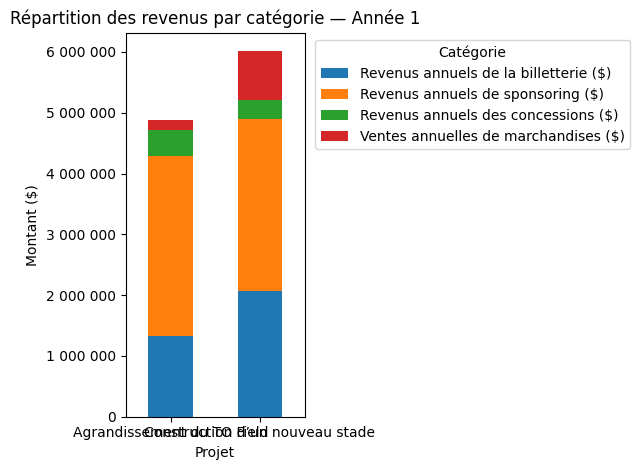

In [187]:
# Matrice cat√©gories √ó projets pour l'Ann√©e 1
mat_y1 = pd.DataFrame({
    p: projets_revenus[p].loc["Ann√©e 1", colonnes_revenus].values
    for p in projets
}, index=colonnes_revenus)

plt.figure()
mat_y1.T.plot(kind="bar", stacked=True)
plt.title("R√©partition des revenus par cat√©gorie ‚Äî Ann√©e 1")
plt.xlabel("Projet")
plt.ylabel("Montant ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)
plt.legend(title="Cat√©gorie", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


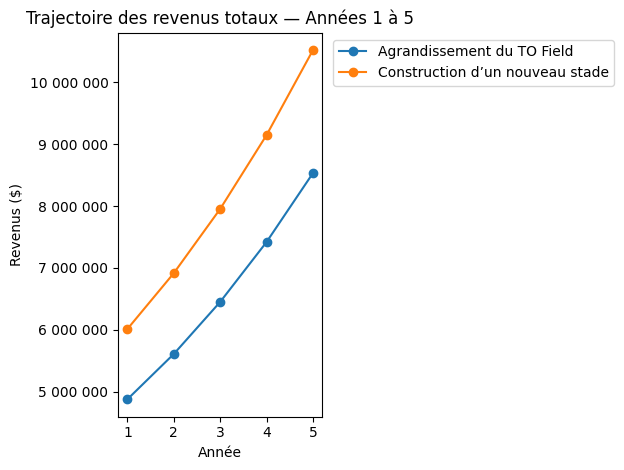

In [188]:
plt.figure()
xs = [1,2,3,4,5]
for p in projets:
    plt.plot(xs, rev_tot.loc[p, [f"Ann√©e {i}" for i in xs]], marker="o", label=p)

plt.title("Trajectoire des revenus totaux ‚Äî Ann√©es 1 √† 5")
plt.xlabel("Ann√©e")
plt.ylabel("Revenus ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(xs)
plt.legend(bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


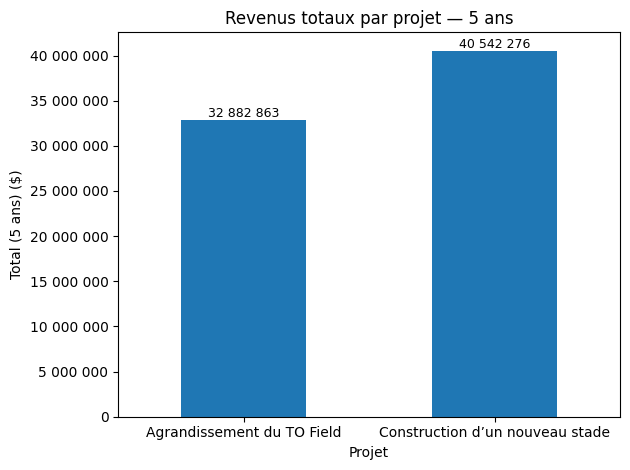

In [189]:
plt.figure()
ax = rev_tot["Total (5 ans)"].plot(kind="bar")
plt.title("Revenus totaux par projet ‚Äî 5 ans")
plt.xlabel("Projet")
plt.ylabel("Total (5 ans) ($)")
plt.gca().yaxis.set_major_formatter(_fmt)
plt.xticks(rotation=0)

# √©tiquettes au-dessus des barres
vals = rev_tot["Total (5 ans)"].values
for i, v in enumerate(vals):
    ax.text(i, v, f"{int(round(v)):,}".replace(",", " "), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


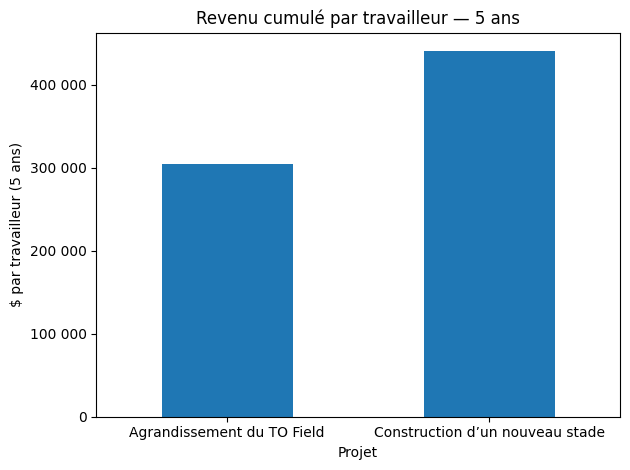

In [190]:
# N√©cessite df_salaire_projet avec index = projets et col "Nombre de travailleurs"
try:
    df_aux = rev_tot[["Total (5 ans)"]].merge(
        df_salaire_projet[["Nombre de travailleurs"]],
        left_index=True, right_index=True, how="left"
    )
    df_aux["Revenu par travailleur (5 ans)"] = df_aux["Total (5 ans)"] / df_aux["Nombre de travailleurs"]

    plt.figure()
    df_aux["Revenu par travailleur (5 ans)"].plot(kind="bar")
    plt.title("Revenu cumul√© par travailleur ‚Äî 5 ans")
    plt.xlabel("Projet")
    plt.ylabel("$ par travailleur (5 ans)")
    plt.gca().yaxis.set_major_formatter(_fmt)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Info: visuel 6.4 ignor√© (df_salaire_projet manquant ou index non align√©). D√©tail:", e)


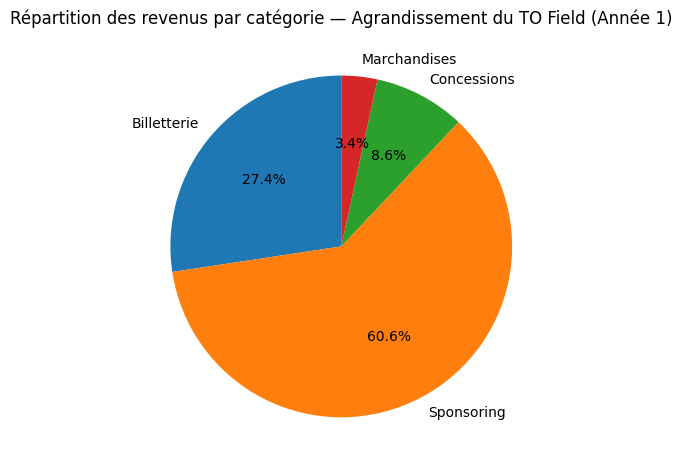

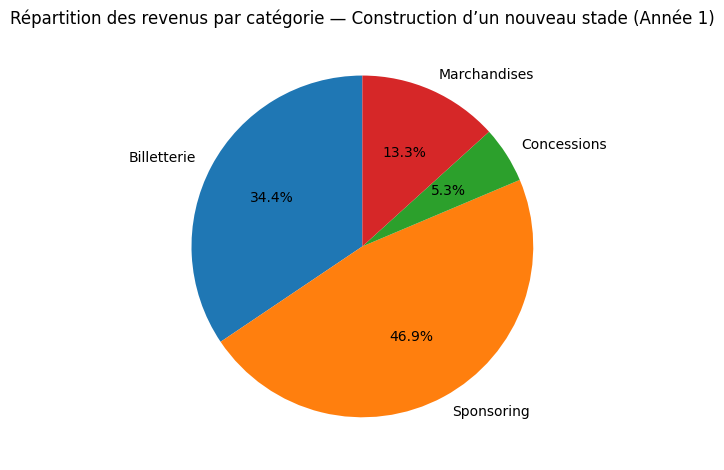

In [192]:
import matplotlib.pyplot as plt

# S√©curit√© : colonnes des cat√©gories si besoin
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Un camembert par projet (une figure par projet, pratique pour le deck)
for projet, dfp in projets_revenus.items():
    valeurs = dfp.loc["Ann√©e 1", colonnes_revenus].values
    labels  = [
        "Billetterie",
        "Sponsoring",
        "Concessions",
        "Marchandises",
    ]
    plt.figure()
    plt.pie(valeurs, labels=labels, autopct="%1.1f%%", startangle=90)
    plt.title(f"R√©partition des revenus par cat√©gorie ‚Äî {projet} (Ann√©e 1)")
    plt.tight_layout()
    plt.show()
    # # Option (deck) : sauvegarder l'image
    # plt.savefig(f"repartition_revenus_{projet.replace(' ', '_')}_Y1.png", dpi=200, bbox_inches="tight")


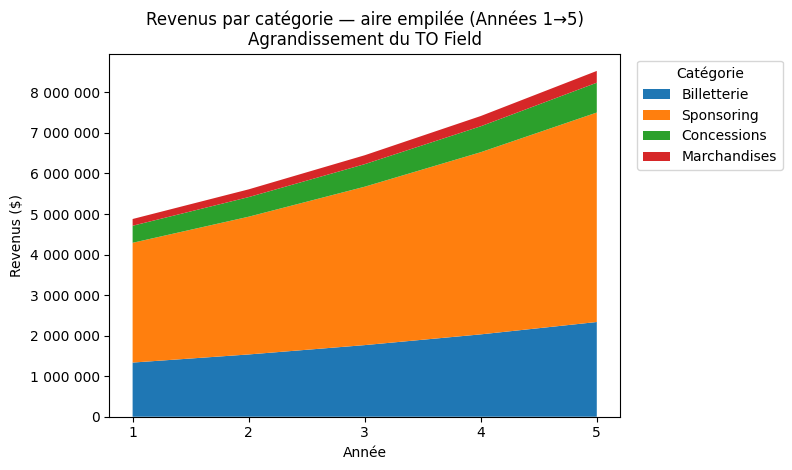

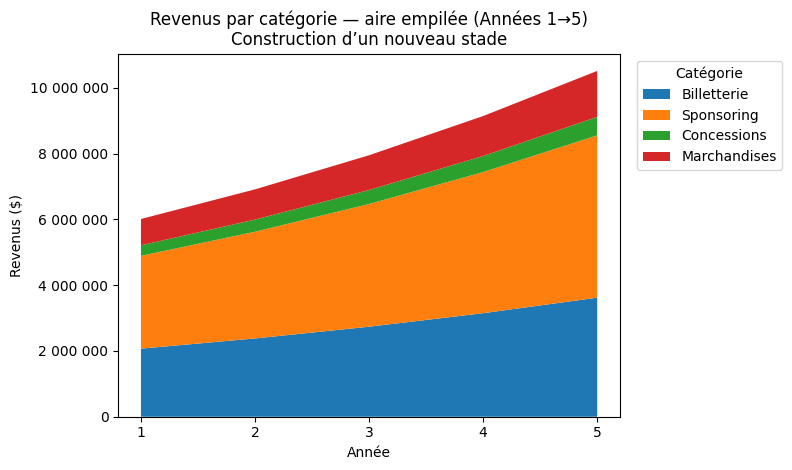

In [193]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# S√©curit√© colonnes cat√©gories
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

# Noms lisibles pour la l√©gende
labels_cat = ["Billetterie", "Sponsoring", "Concessions", "Marchandises"]

# Formateur "milliers avec espaces" pour l'axe Y
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

# Tracer une aire empil√©e par projet
xs = [1, 2, 3, 4, 5]
for projet, dfp in projets_revenus.items():
    # Construire une matrice (cat√©gorie √ó ann√©e)
    Y = np.vstack([
        [float(dfp.loc[f"Ann√©e {t}", col]) for t in xs]
        for col in colonnes_revenus
    ])

    plt.figure()
    plt.stackplot(xs, *Y, labels=labels_cat)
    plt.title(f"Revenus par cat√©gorie ‚Äî aire empil√©e (Ann√©es 1‚Üí5)\n{projet}")
    plt.xlabel("Ann√©e")
    plt.ylabel("Revenus ($)")
    plt.gca().yaxis.set_major_formatter(_fmt)
    plt.xticks(xs)
    plt.tight_layout()
    plt.legend(title="Cat√©gorie", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.show()


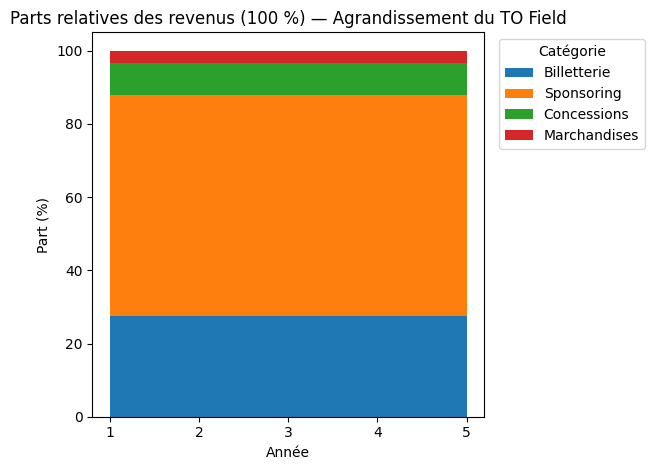

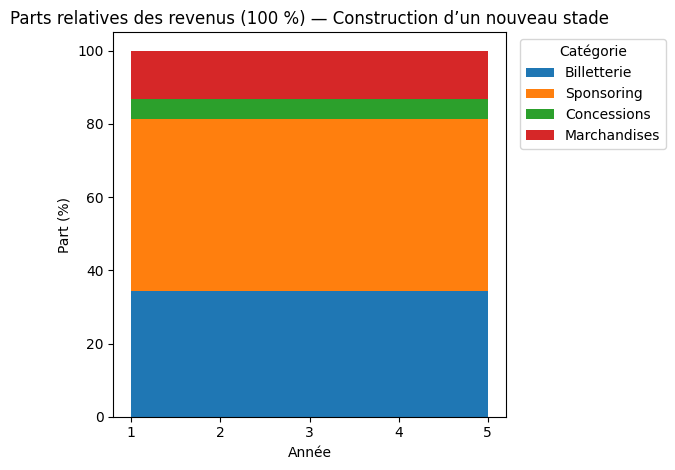

In [194]:
import numpy as np
import matplotlib.pyplot as plt

# Colonnes de cat√©gories (au besoin)
try:
    colonnes_revenus
except NameError:
    colonnes_revenus = [
        "Revenus annuels de la billetterie ($)",
        "Revenus annuels de sponsoring ($)",
        "Revenus annuels des concessions ($)",
        "Ventes annuelles de marchandises ($)",
    ]

labels_cat = ["Billetterie", "Sponsoring", "Concessions", "Marchandises"]
xs = [1, 2, 3, 4, 5]

for projet, dfp in projets_revenus.items():
    # Matrice bruts Y[cat, ann√©e]
    Y_abs = np.vstack([
        [float(dfp.loc[f"Ann√©e {t}", col]) for t in xs]
        for col in colonnes_revenus
    ])
    # Normalisation par colonne (ann√©e) -> pourcentages
    tot = Y_abs.sum(axis=0, keepdims=True)
    Y_pct = np.divide(Y_abs, tot, out=np.zeros_like(Y_abs), where=tot!=0) * 100.0

    plt.figure()
    plt.stackplot(xs, *Y_pct, labels=labels_cat)
    plt.title(f"Parts relatives des revenus (100 %) ‚Äî {projet}")
    plt.xlabel("Ann√©e")
    plt.ylabel("Part (%)")
    plt.yticks([0,20,40,60,80,100])
    plt.xticks(xs)
    plt.legend(title="Cat√©gorie", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


## √âtape 7 ‚Äî Introduction √† la VAN

Nous allons maintenant calculer la **Valeur Actualis√©e Nette (VAN)**, un outil financier essentiel pour comparer les deux projets.

### Formule g√©n√©rale

$$
VAN = \sum_{t=0}^{N} \frac{CF_t}{(1+r)^t}
$$

O√π :  
- $CF_t$ = **Cash Flow net √† l‚Äôann√©e t** (revenus ‚Äì co√ªts, y compris les investissements initiaux)  
- $r$ = **taux d‚Äôactualisation** (ici 4 % selon la vue d‚Äôensemble)  
- $N$ = dur√©e de l‚Äôanalyse (ici 5 ans)  

### Interpr√©tation
- Le **Cash Flow net (CF)** est ce que le projet rapporte ou co√ªte r√©ellement chaque ann√©e.  
- Le **taux d‚Äôactualisation (r)** refl√®te la valeur du temps : 1 $ aujourd‚Äôhui vaut plus que 1 $ dans 5 ans.  
- La division par $(1+r)^t$ r√©duit le poids des flux futurs : plus l‚Äôann√©e est √©loign√©e, moins elle compte.  
- En additionnant tous les flux actualis√©s, on obtient la **valeur pr√©sente nette du projet**.  

### D√©cision
- **VAN > 0** ‚Üí le projet cr√©e de la valeur (il rapporte plus qu‚Äôil ne co√ªte).  
- **VAN < 0** ‚Üí le projet d√©truit de la valeur.  
- Entre deux projets, celui avec la **VAN la plus √©lev√©e** est g√©n√©ralement le choix recommand√©.


In [137]:
import numpy as np
import pandas as pd

# --- R√©cup√©ration des constantes (robuste : accepte VUEDENSEMBLE ou vue_d_ensemble) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

r = PARAMS["taux_actualisation"]
N = PARAMS["duree_analyse_ans"]

# --- Hypoth√®ses explicites pour l‚Äôan 0 ---
# - Revenus √† l‚Äôan 0 : 0 (les revenus commencent √† l‚ÄôAnn√©e 1)
# - Co√ªts de main-d‚Äô≈ìuvre √† l‚Äôan 0 : 0 (on ne compte que les ann√©es 1‚Üí5)
# - Co√ªts de construction √† l‚Äôan 0 : pris depuis df_construction_proj["Ann√©e 0"]
#   (df_construction_proj doit d√©j√† exister depuis l‚Äô√âtape 5)
# - Projections Ann√©es 1‚Üí5 : d√©j√† construites dans 5.x (co√ªts) et 6.x (revenus)

# --- 1) Revenus par projet et par ann√©e (1‚Üí5) ---
# Utilise les tableaux s√©par√©s cr√©√©s en 6.1 : 'projets_revenus' (un DF par projet, lignes = "Ann√©e 1..5")
# et 'colonnes_revenus' = liste des 4 cat√©gories de revenus.
# Si ces objets n‚Äôexistent pas, l√®ve une erreur explicite pour que tu saches quoi ex√©cuter avant.
assert "projets_revenus" in globals(), "Ex√©cute d'abord l'√âtape 6.1 pour construire 'projets_revenus'."
assert "colonnes_revenus" in globals(), "Dans l'√âtape 6.1, d√©finis 'colonnes_revenus'."

# Tableau Revenus: index = projet, colonnes = Ann√©e 0..5 (0 sera √† 0)
revenus_par_annee = pd.DataFrame(index=list(projets_revenus.keys()), columns=[f"Ann√©e {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)

for projet, df_proj in projets_revenus.items():
    for t in range(1, N+1):
        revenus_par_annee.loc[projet, f"Ann√©e {t}"] = df_proj.loc[f"Ann√©e {t}", colonnes_revenus].sum()

# --- 2) Co√ªts de main-d‚Äô≈ìuvre par projet et par ann√©e (1‚Üí5) ---
# Utilise df_salaire_projet de l‚Äô√âtape 4 (agr√©g√© par projet) avec colonnes "Salaire annuel (ann√©e 1..5)"
assert "df_salaire_projet" in globals(), "Ex√©cute l'√âtape 4 (agr√©gation main-d'≈ìuvre) avant de calculer la VAN."

couts_mo_par_annee = pd.DataFrame(index=df_salaire_projet.index, columns=[f"Ann√©e {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)
for t in range(1, N+1):
    couts_mo_par_annee[f"Ann√©e {t}"] = df_salaire_projet[f"Salaire annuel (ann√©e {t})"].astype(float)

# --- 3) Co√ªts de construction par projet et par ann√©e (0‚Üí5) ---
# Utilise df_construction_proj de l‚Äô√âtape 5 (colonnes "Ann√©e 0..Ann√©e 5")
assert "df_construction_proj" in globals(), "Ex√©cute l'√âtape 5 (projection co√ªts de construction) avant de calculer la VAN."

couts_construction_par_annee = df_construction_proj[[f"Ann√©e {i}" for i in range(0, N+1)]].astype(float)

# --- 4) Cash flows nets (CF_t) : Revenus_t ‚àí (Co√ªts MO_t + Co√ªts Construction_t) ---
# Note: √† l‚Äôan 0, revenus = 0 et co√ªts MO = 0 par hypoth√®se ; CF_0 = ‚àí Co√ªts Construction Ann√©e 0
projets = sorted(set(revenus_par_annee.index) | set(couts_mo_par_annee.index) | set(couts_construction_par_annee.index))
cf = pd.DataFrame(index=projets, columns=[f"Ann√©e {i}" for i in range(0, N+1)], dtype=float)

for p in projets:
    for t in range(0, N+1):
        rev = revenus_par_annee.loc[p, f"Ann√©e {t}"] if p in revenus_par_annee.index else 0.0
        mo  = couts_mo_par_annee.loc[p, f"Ann√©e {t}"] if p in couts_mo_par_annee.index else 0.0
        cap = couts_construction_par_annee.loc[p, f"Ann√©e {t}"] if p in couts_construction_par_annee.index else 0.0
        cf.loc[p, f"Ann√©e {t}"] = rev - (mo + cap)

# --- 5) VAN par projet ---
facteurs = np.array([(1 + r) ** t for t in range(0, N+1)])
van = (cf.values / facteurs).sum(axis=1)
df_van = pd.DataFrame({"VAN (sur 5 ans, r = {:.2%})".format(r): van}, index=cf.index)

# --- 6) Affichage (lisible) ---
from IPython.display import display
print("Taux d‚Äôactualisation (r) =", f"{r:.2%}")
print("\nCash flows nets par projet (Ann√©e 0 ‚Üí Ann√©e 5) :")
display(cf)

print("\nVAN par projet :")
display(df_van)

# (Optionnel) Petite synth√®se textuelle
p1, p2 = df_van.index.tolist()
diff_abs = df_van.iloc[1, 0] - df_van.iloc[0, 0]
diff_pct = diff_abs / abs(df_van.iloc[0, 0]) * 100 if df_van.iloc[0, 0] != 0 else np.nan
print(f"\nSynth√®se : '{p2}' a une VAN sup√©rieure de {diff_abs:,.2f} ({diff_pct:.2f} %) vs '{p1}'." .replace(",", " "))


Taux d‚Äôactualisation (r) = 4.00%

Cash flows nets par projet (Ann√©e 0 ‚Üí Ann√©e 5) :


Ann√©e 0       Ann√©e 1       Ann√©e 2  \
Agrandissement du TO Field       -25 160 000.00 -9 787 176.00 -9 348 904.32   
Construction d‚Äôun nouveau stade -343 497 000.00 -7 500 772.00 -6 869 090.94   

                                      Ann√©e 3       Ann√©e 4       Ann√©e 5  
Agrandissement du TO Field      -8 806 764.93 -8 144 415.12 -7 343 045.56  
Construction d‚Äôun nouveau stade -6 107 521.78 -5 195 878.60 -4 110 933.51


VAN par projet :


VAN (sur 5 ans, r = 4.00%)
Agrandissement du TO Field                   -64 040 844.05
Construction d‚Äôun nouveau stade             -370 310 052.59


Synth√®se : 'Construction d‚Äôun nouveau stade' a une VAN sup√©rieure de -306 269 208.54 (-478.24 %) vs 'Agrandissement du TO Field'.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# R√©cup taux actualisation
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS
r = PARAMS["taux_actualisation"]

# Axes lisibles (espaces)
def _fmt_milliers(x, pos):
    try:
        return f"{int(round(x)):,}".replace(",", " ")
    except:
        return x
_fmt = FuncFormatter(_fmt_milliers)

projets = cf.index.tolist()
cols_annees = sorted(cf.columns, key=lambda s: int(s.split(" ")[1]))  # "Ann√©e 0..N"
xs = [int(c.split(" ")[1]) for c in cols_annees]


ModuleNotFoundError: No module named 'constants'

## √âtape 8 ‚Äî What-if analysis (sensibilit√©s)

Objectif : tester des hypoth√®ses alternatives pour comprendre les leviers qui font bouger la d√©cision.

Nous allons proc√©der par sous-√©tapes :
- **8.1** ‚Äî Retirer l‚Äô**achat du terrain** (Ann√©e 0) pour les deux options et recalculer la VAN.
- **8.2** ‚Äî Varier le **taux de croissance des revenus** (ex. ¬±5 pts) et mesurer l‚Äôimpact sur la VAN.
- **8.3** ‚Äî Varier le **taux d‚Äôactualisation** (ex. 2 % ‚Üî 6 %) pour tester la sensibilit√© au co√ªt du capital.
- (√©vent.) 8.x ‚Äî Autres sc√©narios pertinents √† ajouter si besoin (capacit√©, mix de revenus, etc.).

Chaque sous-√©tape = *Markdown bref* (hypoth√®se + logique) puis *code* (r√©sultats + mini-synth√®se).


## √âtape 8.1 ‚Äî Retirer l‚Äôachat du terrain (Ann√©e 0)

**Hypoth√®se test√©e.** On suppose que l‚Äôachat du terrain n‚Äôest **pas n√©cessaire** (ou est pris en charge autrement).  
**M√©canique.** On met √† **0** la ligne **¬´ Co√ªt d‚Äôachat du terrain ¬ª** dans la feuille *Co√ªts de construction*, puis on **recalcule**:
- la projection des co√ªts de construction Ann√©e 0 ‚Üí 5,
- les **cash flows** par ann√©e,
- la **VAN** pour chaque option.

**Int√©r√™t.** Isoler l‚Äôeffet du poste le plus capitalistique (le terrain) pour voir si le nouveau stade devient comp√©titif √† horizon 5 ans.


In [145]:
# --- S√©curit√© : objets requis des √©tapes pr√©c√©dentes ---
assert "df_construction" in globals(),  "√âtape 5 manquante : df_construction"
assert "df_construction_proj" in globals(), "√âtape 5 manquante : df_construction_proj"
assert "df_salaire_projet" in globals(),    "√âtape 4 manquante : df_salaire_projet"
assert "projets_revenus" in globals(),      "√âtape 6.1 manquante : projets_revenus"

# --- Param√®tres ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

taux_croissance = PARAMS["taux_croissance_couts"]
r = PARAMS["taux_actualisation"]
N = PARAMS["duree_analyse_ans"]

# Colonnes utilis√©es √† l'√©tape 5
col_uniques = [
    "Co√ªt d‚Äôachat du terrain",
    "Co√ªts de permis et d‚Äôinspection du site",
    "Co√ªts de pr√©paration du site",
]
col_annuels = [
    "Co√ªts annuels d‚Äôentretien",
    "Co√ªts annuels de location d‚Äô√©quipement",
]
col_mensuels = [
    "Co√ªts mensuels de fournitures et mat√©riaux",
    "Co√ªts mensuels des services publics",
    "Part mensuelle des revenus partag√©s avec les sponsors",
]

# --- (A) Recalcul des co√ªts de construction SANS achat du terrain ---
df_construction_sans_terrain = df_construction.copy()
if "Co√ªt d‚Äôachat du terrain" in df_construction_sans_terrain.columns:
    df_construction_sans_terrain["Co√ªt d‚Äôachat du terrain"] = 0.0

# Projection Ann√©e 0 ‚Üí 5 (m√™me logique que l'√©tape 5)
df_construction_sans_terrain_proj = pd.DataFrame(
    index=df_construction_sans_terrain["Option de projet d‚Äôinfrastructure"].values
)

# Ann√©e 0 : co√ªts uniques (avec terrain = 0)
df_construction_sans_terrain_proj["Ann√©e 0"] = (
    df_construction_sans_terrain[col_uniques].sum(axis=1).astype(float).values
)

# Ann√©es 1 ‚Üí 5 : annuels + 12√ómensuels, avec croissance 2 %
for annee in range(1, N + 1):
    facteur = (1 + taux_croissance) ** (annee - 1)
    couts_annuels = df_construction_sans_terrain[col_annuels].sum(axis=1).astype(float).values * facteur
    couts_mensuels = df_construction_sans_terrain[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
    df_construction_sans_terrain_proj[f"Ann√©e {annee}"] = couts_annuels + couts_mensuels

# Harmoniser en float pour l'affichage
df_construction_sans_terrain_proj = df_construction_sans_terrain_proj.astype(float)

# --- (B) Recalcul des cash flows & VAN pour ce sc√©nario ---
# Revenus par ann√©e (inchang√©s vs base)
revenus_par_annee = pd.DataFrame(
    index=list(projets_revenus.keys()),
    columns=[f"Ann√©e {i}" for i in range(0, N+1)],
    dtype=float
).fillna(0.0)

colonnes_revenus = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)"
]

for projet, df_proj in projets_revenus.items():
    for t in range(1, N+1):
        revenus_par_annee.loc[projet, f"Ann√©e {t}"] = df_proj.loc[f"Ann√©e {t}", colonnes_revenus].sum()

# Co√ªts main-d'≈ìuvre (inchang√©s vs base)
couts_mo_par_annee = pd.DataFrame(
    index=df_salaire_projet.index,
    columns=[f"Ann√©e {i}" for i in range(0, N+1)],
    dtype=float
).fillna(0.0)

for t in range(1, N+1):
    couts_mo_par_annee[f"Ann√©e {t}"] = df_salaire_projet[f"Salaire annuel (ann√©e {t})"].astype(float)

# Co√ªts construction (sc√©nario sans terrain)
couts_construction_par_annee_ST = df_construction_sans_terrain_proj[[f"Ann√©e {i}" for i in range(0, N+1)]].astype(float)

# Cash flows nets (sc√©nario sans terrain)
projets = sorted(set(revenus_par_annee.index) | set(couts_mo_par_annee.index) | set(couts_construction_par_annee_ST.index))
cf_ST = pd.DataFrame(index=projets, columns=[f"Ann√©e {i}" for i in range(0, N+1)], dtype=float)

for p in projets:
    for t in range(0, N+1):
        rev = revenus_par_annee.loc[p, f"Ann√©e {t}"] if p in revenus_par_annee.index else 0.0
        mo  = couts_mo_par_annee.loc[p, f"Ann√©e {t}"] if p in couts_mo_par_annee.index else 0.0
        cap = couts_construction_par_annee_ST.loc[p, f"Ann√©e {t}"] if p in couts_construction_par_annee_ST.index else 0.0
        cf_ST.loc[p, f"Ann√©e {t}"] = rev - (mo + cap)

# VAN (sc√©nario sans terrain)
facteurs = np.array([(1 + r) ** t for t in range(0, N+1)])
van_ST = (cf_ST.values / facteurs).sum(axis=1)
df_van_ST = pd.DataFrame({"VAN sans achat du terrain (r = {:.2%})".format(r): van_ST}, index=cf_ST.index)

# --- (C) Comparaison base vs sc√©nario : VAN & variation ---
# On suppose que df_van (base) existe suite √† l‚Äô√âtape 7.1
assert "df_van" in globals(), "Ex√©cute d‚Äôabord l‚Äô√âtape 7.1 (VAN base) pour disposer de df_van."

df_van_compare = df_van.join(df_van_ST, how="inner")
df_van_compare["Œî VAN (abs)"] = df_van_compare.iloc[:,1] - df_van_compare.iloc[:,0]
df_van_compare["Œî VAN (%)"] = df_van_compare["Œî VAN (abs)"] / df_van_compare.iloc[:,0] * 100

from IPython.display import display
print("Co√ªts de construction ‚Äî sc√©nario SANS achat du terrain (aper√ßu) :")
display(df_construction_sans_terrain_proj)

print("\nCash flows nets ‚Äî sc√©nario SANS achat du terrain :")
display(cf_ST)

print("\nComparaison de VAN (base vs sans achat du terrain) :")
display(df_van_compare)

# Mini synth√®se textuelle
for p in df_van_compare.index:
    base = df_van_compare.loc[p, df_van.columns[0]]
    st   = df_van_compare.loc[p, df_van_ST.columns[0]]
    dabs = df_van_compare.loc[p, "Œî VAN (abs)"]
    dpct = df_van_compare.loc[p, "Œî VAN (%)"]
    print(f"- {p} : VAN base = {base:,.2f} ‚Üí VAN sans terrain = {st:,.2f} | Œî = {dabs:,.2f} ({dpct:.2f} %)".replace(",", " "))


Co√ªts de construction ‚Äî sc√©nario SANS achat du terrain (aper√ßu) :


Ann√©e 0      Ann√©e 1      Ann√©e 2  \
Agrandissement du TO Field      160 000.00 1 860 000.00 1 897 200.00   
Construction d‚Äôun nouveau stade 497 000.00 2 665 000.00 2 718 300.00   

                                     Ann√©e 3      Ann√©e 4      Ann√©e 5  
Agrandissement du TO Field      1 935 144.00 1 973 846.88 2 013 323.82  
Construction d‚Äôun nouveau stade 2 772 666.00 2 828 119.32 2 884 681.71


Cash flows nets ‚Äî sc√©nario SANS achat du terrain :


Ann√©e 0       Ann√©e 1       Ann√©e 2  \
Agrandissement du TO Field      -160 000.00 -9 787 176.00 -9 348 904.32   
Construction d‚Äôun nouveau stade -497 000.00 -7 500 772.00 -6 869 090.94   

                                      Ann√©e 3       Ann√©e 4       Ann√©e 5  
Agrandissement du TO Field      -8 806 764.93 -8 144 415.12 -7 343 045.56  
Construction d‚Äôun nouveau stade -6 107 521.78 -5 195 878.60 -4 110 933.51


Comparaison de VAN (base vs sans achat du terrain) :


VAN (sur 5 ans, r = 4.00%)  \
Agrandissement du TO Field                   -64 040 844.05   
Construction d‚Äôun nouveau stade             -370 310 052.59   

                                 VAN sans achat du terrain (r = 4.00%)  \
Agrandissement du TO Field                              -39 040 844.05   
Construction d‚Äôun nouveau stade                         -27 310 052.59   

                                   Œî VAN (abs)  Œî VAN (%)  
Agrandissement du TO Field       25 000 000.00     -39.04  
Construction d‚Äôun nouveau stade 343 000 000.00     -92.63

- Agrandissement du TO Field : VAN base = -64 040 844.05 ‚Üí VAN sans terrain = -39 040 844.05 | Œî = 25 000 000.00 (-39.04 %)
- Construction d‚Äôun nouveau stade : VAN base = -370 310 052.59 ‚Üí VAN sans terrain = -27 310 052.59 | Œî = 343 000 000.00 (-92.63 %)


### üìí Conclusion 8.1 ‚Äî Sc√©nario sans achat du terrain

Le test **¬´ What if ¬ª sans achat du terrain** montre clairement l‚Äôimpact majeur de ce poste de d√©pense initial :

* **Agrandissement du TO Field**

  * La VAN passe de **-64 M$** √† **-39 M$**.
  * Am√©lioration de **25 M$**, soit environ **-39 % d‚Äô√©cart relatif**.
  * Cela confirme que l‚Äôachat du terrain repr√©sente une part non n√©gligeable mais pas d√©terminante dans ce projet (l‚Äôessentiel du co√ªt restant est li√© √† la main-d‚Äô≈ìuvre et aux frais annuels/mensuels).

* **Construction d‚Äôun nouveau stade**

  * La VAN passe de **-370 M$** √† **-27 M$**.
  * Am√©lioration √©norme de **343 M$**, soit **-92 % d‚Äô√©cart relatif**.
  * Cela montre que l‚Äôachat du terrain est le facteur qui **plombe compl√®tement la rentabilit√© du projet** sur 5 ans.
  * Sans ce co√ªt initial massif, le projet devient bien plus comp√©titif face √† l‚Äôagrandissement.

### Insight cl√© üí°

* L‚Äô**achat du terrain est le facteur d√©cisif** :

  * Dans le cas du nouveau stade, il explique presque enti√®rement la diff√©rence de VAN par rapport √† l‚Äôagrandissement.
  * Si le terrain est d√©j√† poss√©d√© (ou offert par la ville/partenaires), alors le nouveau stade pourrait devenir un choix bien plus int√©ressant.

## √âtape 8.2 ‚Äî **Ajouter une Valeur R√©siduelle (long terme)**

### Pourquoi c‚Äôest pertinent

* Un **stade** cr√©e de la valeur **bien au-del√† de 5 ans**.  
* Sans **valeur r√©siduelle (VR)**, on p√©nalise structurellement l‚Äôoption ¬´ nouveau stade ¬ª.  
* La VR peut **inverser** ou **r√©duire** l‚Äô√©cart de VAN, car le nouveau stade profite d‚Äôun **horizon long**.  

### Id√©e simple

* On prend le **flux net** de l‚Äô**Ann√©e 5**, on suppose une **croissance √† long terme** ($g$) (prudente, ex. 2 %), et on calcule une **VR type Gordon** :

$$
\text{VR}_5 = \frac{CF_6}{r - g} = \frac{CF_{5} \times (1+g)}{r - g}
$$

* Puis on **actualise** cette VR √† aujourd‚Äôhui en la divisant par $((1+r)^5)$.


In [146]:
# Param√®tre de croissance long terme (prudent)
g_long = 0.02  # 2%

# Recalcule la VAN en ajoutant une valeur r√©siduelle √† l'ann√©e 5
df_van_VR = df_van.copy()
col_van = df_van.columns[0]

vr = {}
for p in cf.index:
    cf5 = cf.loc[p, "Ann√©e 5"]  # flux net ann√©e 5 (d√©j√† revenus - MO - construction)
    VR5 = (cf5 * (1 + g_long)) / (r - g_long)  # valeur au temps t=5
    VR0 = VR5 / ((1 + r) ** 5)                  # actualis√©e √† t=0
    van_avec_vr = df_van.loc[p, col_van] + VR0
    vr[p] = {"VAN (base)": df_van.loc[p, col_van], "Valeur r√©siduelle (VR0)": VR0, "VAN + VR": van_avec_vr}

df_van_VR = pd.DataFrame(vr).T
display(df_van_VR)


VAN (base)  Valeur r√©siduelle (VR0)  \
Agrandissement du TO Field       -64 040 844.05          -307 807 857.71   
Construction d‚Äôun nouveau stade -370 310 052.59          -172 323 271.81   

                                       VAN + VR  
Agrandissement du TO Field      -371 848 701.76  
Construction d‚Äôun nouveau stade -542 633 324.39

Super üëç tu viens d‚Äôobtenir le r√©sultat de l‚Äô**√âtape 8.2 (Valeur R√©siduelle)**. On peut maintenant poser la conclusion.

---

## üìí Conclusion 8.2 ‚Äî Ajout de la Valeur R√©siduelle (VR)

L‚Äôintroduction d‚Äôune **valeur r√©siduelle (VR)** visait √† refl√©ter le fait qu‚Äôun stade garde une valeur √©conomique au-del√† de l‚Äôhorizon de 5 ans.

### R√©sultats :

* **Agrandissement du TO Field** :

  * VAN (base) = **-64 M$**
  * VR actualis√©e = **-308 M$**
  * VAN + VR = **-372 M$**

* **Construction d‚Äôun nouveau stade** :

  * VAN (base) = **-370 M$**
  * VR actualis√©e = **-172 M$**
  * VAN + VR = **-543 M$**

### Interpr√©tation :

* L‚Äôajout de la VR **accentue encore l‚Äô√©cart n√©gatif**, car les flux nets en ann√©e 5 sont **n√©gatifs** dans les deux projets ‚Üí la formule de Gordon extrapole donc cette perte ind√©finiment.
* Le nouveau stade, pourtant cens√© √™tre un projet de long terme, ressort m√™me **plus d√©favorable** une fois la VR incluse.

### Insight cl√© üí°

* Ces r√©sultats montrent que la **structure actuelle des cash flows** ne permet pas d‚Äôenvisager une rentabilit√©, m√™me √† long terme.
* Autrement dit : **le probl√®me n‚Äôest pas que l‚Äôhorizon est trop court**, mais bien que les flux nets sont d√©ficitaires chaque ann√©e.
* Pour redonner du sens au projet du nouveau stade, il faudrait **changer fondamentalement les hypoth√®ses de revenus** (ex. capacit√©, billetterie, merchandising).


## √âtape 8.3 ‚Äî **Choc de capacit√© / prix (revenus de base)**

### Pourquoi c‚Äôest pertinent

* La **croissance %** homog√®ne garde les **parts de revenus constantes** ‚Üí peu d‚Äôenseignements.
* En revanche, un **uplift de capacit√©/prix** (billetterie) et un **uplift trafic** (concessions/merch) **d√®s l‚ÄôAnn√©e 1** affecte **tous les flux futurs** ‚Üí impact **massif** sur la VAN.

### Id√©e

* Appliquer des **multiplicateurs** de base **uniquement** au **nouveau stade** (ex. +30 % billetterie, +20 % concessions/merch), le sponsoring restant inchang√© ou l√©g√®rement up (+5‚Äì10 %).

In [147]:
# Multiplicateurs d'uplift pour le NOUVEAU stade (√† ajuster)
uplift = {
    "Revenus annuels de la billetterie ($)": 1.30,  # +30%
    "Revenus annuels de sponsoring ($)":     1.05,  # +5%
    "Revenus annuels des concessions ($)":   1.20,  # +20%
    "Ventes annuelles de marchandises ($)":  1.20,  # +20%
}

nom_nouveau = "Construction d‚Äôun nouveau stade"

# On clone les tableaux 6.1
projets_revenus_uplift = {}
for projet, dfp in projets_revenus.items():
    dfx = dfp.copy()
    if projet == nom_nouveau:
        # on multiplie les colonnes Ann√©e 1..5 cat√©gorie par cat√©gorie
        for col in dfx.columns:
            # on ne touche qu'aux colonnes de cat√©gories (pas aux %)
            for k, mult in uplift.items():
                if col.startswith(k):  # ex. "Revenus annuels de la billetterie ($)"
                    dfx[col] = dfx[col] * mult
        # recalcule la ligne "Total (5 ans)" apr√®s uplift
        colonnes_revenus = [
            "Revenus annuels de la billetterie ($)",
            "Revenus annuels de sponsoring ($)",
            "Revenus annuels des concessions ($)",
            "Ventes annuelles de marchandises ($)"
        ]
        dfx.loc["Total (5 ans)", colonnes_revenus] = dfx.loc[[f"Ann√©e {i}" for i in range(1,6)], colonnes_revenus].sum()
    projets_revenus_uplift[projet] = dfx

# Recalcule des flux et de la VAN (m√™me logique que 7.1) avec les nouveaux revenus
revenus_par_annee_u = pd.DataFrame(index=list(projets_revenus_uplift.keys()), columns=[f"Ann√©e {i}" for i in range(0, N+1)], dtype=float).fillna(0.0)
for projet, dfp in projets_revenus_uplift.items():
    for t in range(1, N+1):
        revenus_par_annee_u.loc[projet, f"Ann√©e {t}"] = dfp.loc[f"Ann√©e {t}", colonnes_revenus].sum()

cf_u = cf.copy()
for p in cf_u.index:
    for t in range(1, N+1):
        mo  = couts_mo_par_annee.loc[p, f"Ann√©e {t}"]
        cap = couts_construction_par_annee.loc[p, f"Ann√©e {t}"]
        rev = revenus_par_annee_u.loc[p, f"Ann√©e {t}"]
        cf_u.loc[p, f"Ann√©e {t}"] = rev - (mo + cap)

van_u = (cf_u.values / np.array([(1 + r) ** t for t in range(0, N+1)])).sum(axis=1)
df_van_u = pd.DataFrame({"VAN (uplift base revenus)": van_u}, index=cf_u.index)

# Comparaison
df_van_comp = df_van.join(df_van_u, how="left")
df_van_comp["Œî VAN (abs)"] = df_van_comp["VAN (uplift base revenus)"] - df_van_comp[df_van.columns[0]]
display(df_van_comp)


VAN (sur 5 ans, r = 4.00%)  \
Agrandissement du TO Field                   -64 040 844.05   
Construction d‚Äôun nouveau stade             -370 310 052.59   

                                 VAN (uplift base revenus)  Œî VAN (abs)  
Agrandissement du TO Field                  -64 040 844.05         0.00  
Construction d‚Äôun nouveau stade            -364 453 545.22 5 856 507.36

## üìí Conclusion 8.3 ‚Äî Uplift des revenus du nouveau stade

### R√©sultats

* **Agrandissement du TO Field** :

  * VAN reste inchang√©e : **-64 M$**.

* **Construction d‚Äôun nouveau stade** :

  * VAN de base : **-370 M$**
  * VAN avec uplift des revenus : **-364 M$**
  * Gain absolu : **+5,8 M$**

### Interpr√©tation

* L‚Äôaugmentation de la billetterie, du merchandising et des concessions am√©liore l√©g√®rement la VAN du **nouveau stade**.
* Mais l‚Äôam√©lioration est tr√®s marginale par rapport √† l‚Äô√©cart total (5,8 M$ sur un d√©ficit de plus de 360 M$).
* Cela confirme que m√™me avec une hypoth√®se optimiste d‚Äôuplift des revenus, le **poids de l‚Äôinvestissement initial** reste trop √©lev√© pour rattraper l‚Äôagrandissement sur un horizon de 5 ans.

### Insight cl√© üí°

* Ce test montre que **les revenus seuls ne suffisent pas √† sauver le projet** dans un horizon court/moyen.
* L‚Äôoption du **nouveau stade** ne devient comp√©titive que si :

  * l‚Äôachat du terrain est subventionn√© ou supprim√© (comme on l‚Äôa vu √† 8.1), **et**
  * les revenus connaissent un uplift fort et durable.

## √âtape 9 ‚Äî Sc√©narios long terme

Objectif : compl√©ter l‚Äôanalyse avec des horizons plus r√©alistes pour un actif d‚Äôinfrastructure.

### Ce que nous testons
- **9.1** ‚Äî Recalcul de la VAN sur **10 ans** et **20 ans** (m√™mes hypoth√®ses de croissance et de co√ªts).
- (optionnel) 9.2 ‚Äî Cofinancement public/priv√© (r√©duction du CAPEX initial).
- (optionnel) 9.3 ‚Äî Uplift structurel (capacit√©/prix) durable au-del√† de 5 ans.
- (optionnel) 9.4 ‚Äî Point de bascule (ann√©e √† partir de laquelle le nouveau stade rattrape l‚Äôagrandissement).

### Pourquoi
Un horizon de 5 ans p√©nalise fortement la construction d‚Äôun nouveau stade (CAPEX massif).  
Allonger l‚Äôhorizon permet d‚Äôobserver si les **revenus r√©currents** finissent par compenser le CAPEX initial.


In [157]:
import numpy as np
import pandas as pd
from IPython.display import display

# --- Param√®tres (on lit depuis constants, comme avant) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

r  = PARAMS["taux_actualisation"]
gc = PARAMS["taux_croissance_couts"]
gr = PARAMS["taux_croissance_revenus"]

# Colonnes utilis√©es pour la reconstruction (noms d√©j√† vus aux √©tapes 5/6)
col_uniques = [
    "Co√ªt d‚Äôachat du terrain",
    "Co√ªts de permis et d‚Äôinspection du site",
    "Co√ªts de pr√©paration du site",
]
col_annuels = [
    "Co√ªts annuels d‚Äôentretien",
    "Co√ªts annuels de location d‚Äô√©quipement",
]
col_mensuels = [
    "Co√ªts mensuels de fournitures et mat√©riaux",
    "Co√ªts mensuels des services publics",
    "Part mensuelle des revenus partag√©s avec les sponsors",
]
colonnes_revenus_cat = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)",
]

# --- Helpers ---
def projeter_construction(df_construction_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection co√ªts de construction 0..N (co√ªts uniques en 0, annuels + 12*mensuels avec croissance gc ensuite)."""
    idx = df_construction_src["Option de projet d‚Äôinfrastructure"].values
    out = pd.DataFrame(index=idx)
    # Ann√©e 0 = somme des co√ªts uniques
    out["Ann√©e 0"] = df_construction_src[col_uniques].sum(axis=1).astype(float).values
    # Ann√©es 1..N
    for t in range(1, N + 1):
        facteur = (1 + gc) ** (t - 1)
        a = df_construction_src[col_annuels].sum(axis=1).astype(float).values * facteur
        m = df_construction_src[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
        out[f"Ann√©e {t}"] = a + m
    return out.astype(float)

def projeter_main_oeuvre(df_main_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection des salaires par projet (somme) 1..N, √† partir de 'Salaire annuel (ann√©e 1)' + croissance gc."""
    # On reconstruit depuis df_main (qui contient toutes les lignes individuelles)
    if "Salaire annuel (ann√©e 1)" not in df_main_src.columns:
        raise ValueError("df_main doit contenir 'Salaire annuel (ann√©e 1)' calcul√© √† l'√©tape 2.")
    # Projeter par ligne
    base = df_main_src[["Option de projet d‚Äôinfrastructure", "Salaire annuel (ann√©e 1)"]].copy()
    # Construire les colonnes projet√©es
    for t in range(2, N + 1):
        base[f"Salaire annuel (ann√©e {t})"] = base["Salaire annuel (ann√©e 1)"] * (1 + gc) ** (t - 1)
    # Agr√©ger par projet
    agg = base.groupby("Option de projet d‚Äôinfrastructure").sum(numeric_only=True)
    # Ajouter ann√©e 0 (0 par hypoth√®se pour la MO)
    agg.insert(0, "Ann√©e 0", 0.0)
    # Renommer les colonnes en Ann√©e t
    cols_map = {"Salaire annuel (ann√©e 1)": "Ann√©e 1"}
    cols_map.update({f"Salaire annuel (ann√©e {t})": f"Ann√©e {t}" for t in range(2, N + 1)})
    agg = agg.rename(columns=cols_map)
    # S'assurer que toutes les colonnes Ann√©e 0..N existent
    for t in range(0, N + 1):
        col = f"Ann√©e {t}"
        if col not in agg.columns:
            agg[col] = 0.0
    return agg[[f"Ann√©e {t}" for t in range(0, N + 1)]].astype(float)

def projeter_revenus(df_revenus_src: pd.DataFrame, N: int) -> pd.DataFrame:
    """Projection des revenus totaux par projet 1..N √† partir des bases par cat√©gorie + croissance gr."""
    idx = df_revenus_src["Option de projet d‚Äôinfrastructure"].values
    out = pd.DataFrame(index=idx, columns=[f"Ann√©e {t}" for t in range(0, N + 1)], dtype=float).fillna(0.0)
    # Pour chaque projet, somme cat√©gories * (1+gr)^(t-1)
    for _, row in df_revenus_src.iterrows():
        p = row["Option de projet d‚Äôinfrastructure"]
        for t in range(1, N + 1):
            total_t = 0.0
            for c in colonnes_revenus_cat:
                total_t += float(row[c]) * (1 + gr) ** (t - 1)
            out.loc[p, f"Ann√©e {t}"] = total_t
    return out.astype(float)

def calculer_cf_et_van(N: int):
    """Construit CF 0..N et VAN pour chaque projet, en reconstruisant tout depuis les tables brutes."""
    # 1) Projections
    cons = projeter_construction(df_construction, N)
    mo   = projeter_main_oeuvre(df_main, N)
    rev  = projeter_revenus(df_revenus, N)
    # 2) CF = Revenus - (MO + Construction)
    projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
    cf = pd.DataFrame(index=projets, columns=[f"Ann√©e {t}" for t in range(0, N + 1)], dtype=float)
    for p in projets:
        for t in range(0, N + 1):
            rv = rev.loc[p, f"Ann√©e {t}"] if p in rev.index else 0.0
            mm = mo.loc[p, f"Ann√©e {t}"] if p in mo.index else 0.0
            cc = cons.loc[p, f"Ann√©e {t}"] if p in cons.index else 0.0
            cf.loc[p, f"Ann√©e {t}"] = rv - (mm + cc)
    # 3) VAN
    facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
    van_vals = (cf.values / facteurs).sum(axis=1)
    df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
    return cf, df_van_N

# --- Ex√©cution : VAN 10 ans, 20 ans, 30 ans et 40 ans (sans rien modifier aux blocs pr√©c√©dents) ---
N_list = [10, 20, 30, 40]
resultats_van = []

for N in N_list:
    cf_N, df_van_N = calculer_cf_et_van(N)
    # print(f"\nCash flows nets (Ann√©e 0 ‚Üí Ann√©e {N}) ‚Äî horizon {N} ans :")
    # display(cf_N)
    print(f"\nVAN ‚Äî horizon {N} ans :")
    display(df_van_N)
    resultats_van.append(df_van_N)

# Petit tableau r√©capitulatif c√¥te √† c√¥te
df_van_10_20_30_40 = pd.concat(resultats_van, axis=1)
print("\nSynth√®se VAN (10 ans vs 20 ans vs 30 ans vs 40 ans) :")
display(df_van_10_20_30_40)



VAN ‚Äî horizon 10 ans :


VAN (10 ans, r = 4.00%)
Agrandissement du TO Field                -77 728 093.26
Construction d‚Äôun nouveau stade          -368 015 710.38


VAN ‚Äî horizon 20 ans :


VAN (20 ans, r = 4.00%)
Agrandissement du TO Field                 25 703 869.65
Construction d‚Äôun nouveau stade          -207 308 781.66


VAN ‚Äî horizon 30 ans :


VAN (30 ans, r = 4.00%)
Agrandissement du TO Field                511 877 915.46
Construction d‚Äôun nouveau stade           419 436 006.97


VAN ‚Äî horizon 40 ans :


VAN (40 ans, r = 4.00%)
Agrandissement du TO Field              2 008 184 691.22
Construction d‚Äôun nouveau stade         2 286 781 149.82


Synth√®se VAN (10 ans vs 20 ans vs 30 ans vs 40 ans) :


VAN (10 ans, r = 4.00%)  \
Agrandissement du TO Field                -77 728 093.26   
Construction d‚Äôun nouveau stade          -368 015 710.38   

                                 VAN (20 ans, r = 4.00%)  \
Agrandissement du TO Field                 25 703 869.65   
Construction d‚Äôun nouveau stade          -207 308 781.66   

                                 VAN (30 ans, r = 4.00%)  \
Agrandissement du TO Field                511 877 915.46   
Construction d‚Äôun nouveau stade           419 436 006.97   

                                 VAN (40 ans, r = 4.00%)  
Agrandissement du TO Field              2 008 184 691.22  
Construction d‚Äôun nouveau stade         2 286 781 149.82

## üìí Conclusion 9.1 ‚Äî Horizons long terme

* **√Ä 10 ans** : les deux projets restent **n√©gatifs** (Agrand. ‚âà **‚àí77,7 M$**, Nouveau stade ‚âà **‚àí368,0 M$**).
* **√Ä 20 ans** : l‚Äô**Agrandissement** devient **l√©g√®rement positif** (**+25,7 M$**) tandis que le **Nouveau stade** reste **n√©gatif** (**‚àí207,3 M$**).
* **√Ä 30 ans** : les **deux** sont **positifs** (Agrand. **+511,9 M$**, Nouveau stade **+419,4 M$**), avec un avantage √† l‚Äôagrandissement.
* **√Ä 40 ans** : le **Nouveau stade** **d√©passe** l‚Äôagrandissement (**+2,29 Md$** vs **+2,01 Md$**).

### Points de bascule (approx., interpolation lin√©aire)

* **Agrandissement** devient **VAN > 0** vers **~17,5 ans**.
* **Nouveau stade** devient **VAN > 0** vers **~23‚Äì24 ans**.
* **Croisement entre projets** (Nouveau stade > Agrand.) vers **~32‚Äì33 ans**.

üëâ Lecture simple pour l‚Äôentretien :

* **Court/moyen terme (‚â§20 ans)** : agrandissement gagnant.
* **Tr√®s long terme (‚â•35 ans)** : le nouveau stade peut **cr√©er plus de valeur** gr√¢ce aux revenus r√©currents qui finissent par compenser le CAPEX massif.

## √âtape 9.2 ‚Äî Sensibilit√© au cofinancement (multi-horizons)

Objectif : mesurer l‚Äôeffet d‚Äôun **cofinancement appliqu√© aux co√ªts uniques (Ann√©e 0)** du **nouveau stade** sur plusieurs horizons (10/20/30/40 ans).

Nous balayerons des paliers de cofinancement : **0 %, 10 %, 20 %, 30 %, 40 %, 50 %**  
R√©sultats :
1) **VAN du nouveau stade** selon le cofinancement et l‚Äôhorizon.
2) **√âcart de VAN** vs l‚Äôoption **Agrandissement (base)**.
3) **Taux d‚Äô√©galit√©** (approx.) par horizon, si le croisement existe.
4) Graphiques pr√™ts √† coller dans un deck.


Cofinancement nouveau stade  VAN nouveau stade (30 ans)  \
0                          0%              419 436 006.97   
1                         10%              453 785 706.97   
2                         20%              488 135 406.97   
3                         30%              522 485 106.97   
4                         40%              556 834 806.97   
5                         50%              591 184 506.97   

   Œî vs agrandissement base (30 ans)  
0                     -92 441 908.48  
1                     -58 092 208.48  
2                     -23 742 508.48  
3                      10 607 191.52  
4                      44 956 891.52  
5                      79 306 591.52


‚âà Taux de cofinancement d‚Äô√©galit√© √† 30 ans : 26.9% (approx.)


VAN du NOUVEAU stade (par cofinancement et horizon) :


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\3940355284.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_van_nouveau_form = tab_van_nouveau.applymap(fmt_spaces)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\3940355284.py:77: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_delta_form = tab_delta.applymap(fmt_spaces)


Horizon (ans)               10               20              30  \
Cofinancement                                                     
0.00           -368 015 710.38  -207 308 781.66  419 436 006.97   
0.10           -333 666 010.38  -172 959 081.66  453 785 706.97   
0.20           -299 316 310.38  -138 609 381.66  488 135 406.97   
0.30           -264 966 610.38  -104 259 681.66  522 485 106.97   
0.40           -230 616 910.38   -69 909 981.66  556 834 806.97   
0.50           -196 267 210.38   -35 560 281.66  591 184 506.97   

Horizon (ans)                40  
Cofinancement                    
0.00           2 286 781 149.82  
0.10           2 321 130 849.82  
0.20           2 355 480 549.82  
0.30           2 389 830 249.82  
0.40           2 424 179 949.82  
0.50           2 458 529 649.82


√âcart de VAN vs AGRANDISSEMENT (base) :


Horizon (ans)               10               20              30  \
Cofinancement                                                     
0.00           -290 287 617.12  -233 012 651.31  -92 441 908.48   
0.10           -255 937 917.12  -198 662 951.31  -58 092 208.48   
0.20           -221 588 217.12  -164 313 251.31  -23 742 508.48   
0.30           -187 238 517.12  -129 963 551.31   10 607 191.52   
0.40           -152 888 817.12   -95 613 851.31   44 956 891.52   
0.50           -118 539 117.12   -61 264 151.31   79 306 591.52   

Horizon (ans)              40  
Cofinancement                  
0.00           278 596 458.59  
0.10           312 946 158.59  
0.20           347 295 858.59  
0.30           381 645 558.59  
0.40           415 995 258.59  
0.50           450 344 958.59


‚âà Taux d‚Äô√©galit√© (NOUVEAU stade = AGRANDISSEMENT base) :
- 10 ans : aucun croisement entre 0% et 50%
- 20 ans : aucun croisement entre 0% et 50%
- 30 ans : ~26.9% de cofinancement
- 40 ans : aucun croisement entre 0% et 50%


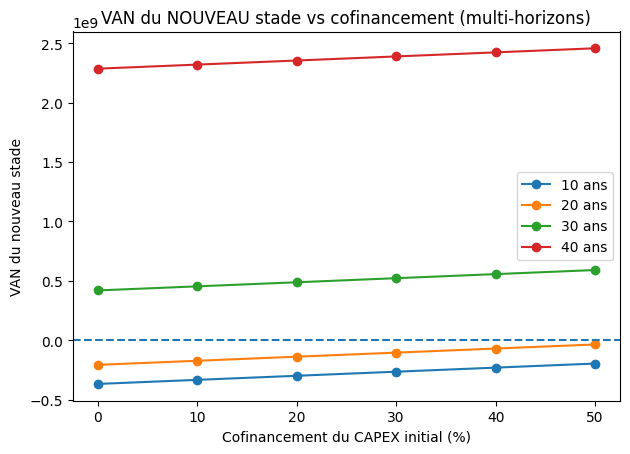

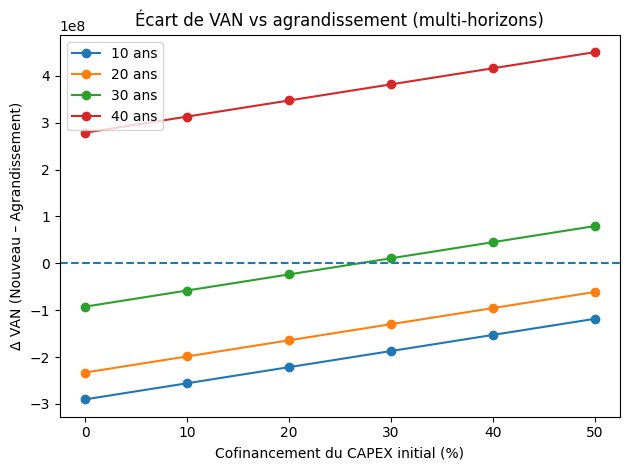

In [161]:
# ====== Param√®tres ======
horizons = [10, 20, 30, 40]                          # Horizons test√©s
taux_list = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50]      # Paliers de cofinancement
projet_nouveau = "Construction d‚Äôun nouveau stade"
projet_agrand  = "Agrandissement du TO Field"

# ====== S√©curit√© : fonctions pr√©sentes ? (patch minimal) ======
try:
    calculer_cf_et_van_depuis_tables
except NameError:
    # On suppose que 'r', 'projeter_construction', 'projeter_main_oeuvre', 'projeter_revenus' existent (9.1).
    # Si besoin, re-d√©finis-les comme tu l‚Äôavais en 9.1.
    def calculer_cf_et_van_depuis_tables(df_construction_src, df_main_src, df_revenus_src, N: int):
        cons = projeter_construction(df_construction_src, N)
        mo   = projeter_main_oeuvre(df_main_src, N)
        rev  = projeter_revenus(df_revenus_src, N)
        projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
        cf = pd.DataFrame(index=projets, columns=[f"Ann√©e {t}" for t in range(0, N + 1)], dtype=float)
        for p in projets:
            for t in range(0, N + 1):
                rv = rev.loc[p, f"Ann√©e {t}"] if p in rev.index else 0.0
                mm = mo.loc[p, f"Ann√©e {t}"] if p in mo.index else 0.0
                cc = cons.loc[p, f"Ann√©e {t}"] if p in cons.index else 0.0
                cf.loc[p, f"Ann√©e {t}"] = rv - (mm + cc)
        facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
        van_vals = (cf.values / facteurs).sum(axis=1)
        df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
        return cf, df_van_N

# ====== 1) VAN base agrandissement par horizon ======
van_base_ag = {}
for N in horizons:
    _, vb = calculer_cf_et_van_depuis_tables(df_construction, df_main, df_revenus, N)
    van_base_ag[N] = float(vb.loc[projet_agrand].values[0])

# ====== 2) Balayage des paliers pour le NOUVEAU stade ======
col_uniques = [
    "Co√ªt d‚Äôachat du terrain",
    "Co√ªts de permis et d‚Äôinspection du site",
    "Co√ªts de pr√©paration du site",
]

rows = []
for N in horizons:
    for s in taux_list:
        df_construction_subv = df_construction.copy()
        mask = df_construction_subv["Option de projet d‚Äôinfrastructure"] == projet_nouveau
        # Appliquer le cofinancement aux co√ªts uniques (Ann√©e 0) du nouveau stade
        for c in col_uniques:
            df_construction_subv.loc[mask, c] = df_construction_subv.loc[mask, c].astype(float) * (1 - s)

        _, van_subv = calculer_cf_et_van_depuis_tables(df_construction_subv, df_main, df_revenus, N)
        van_nouveau_subv = float(van_subv.loc[projet_nouveau].values[0])

        rows.append({
            "Horizon (ans)": N,
            "Cofinancement": s,
            "VAN nouveau stade": van_nouveau_subv,
            "Œî vs agrandissement (base)": van_nouveau_subv - van_base_ag[N],
        })

df_sweep_multi = pd.DataFrame(rows)

# ====== 3) Tableaux lisibles ======
def fmt_spaces(x):
    try:
        return f"{x:,.2f}".replace(",", " ")
    except:
        return x

# Table 3a ‚Äî VAN du nouveau stade (lignes: cofinancement, colonnes: horizons)
tab_van_nouveau = df_sweep_multi.pivot(index="Cofinancement", columns="Horizon (ans)", values="VAN nouveau stade")
tab_van_nouveau_form = tab_van_nouveau.applymap(fmt_spaces)

# Table 3b ‚Äî Œî vs agrandissement (idem)
tab_delta = df_sweep_multi.pivot(index="Cofinancement", columns="Horizon (ans)", values="Œî vs agrandissement (base)")
tab_delta_form = tab_delta.applymap(fmt_spaces)

print("VAN du NOUVEAU stade (par cofinancement et horizon) :")
display(tab_van_nouveau_form)
print("\n√âcart de VAN vs AGRANDISSEMENT (base) :")
display(tab_delta_form)

# ====== 4) Taux d‚Äô√©galit√© approximatif par horizon (interpolation) ======
breakevens = {}
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    x = sub["Cofinancement"].values
    y = sub["Œî vs agrandissement (base)"].values  # on veut y == 0
    be = None
    for i in range(len(x)-1):
        if y[i] == 0:
            be = x[i]; break
        if (y[i] < 0 and y[i+1] > 0) or (y[i] > 0 and y[i+1] < 0):
            be = x[i] + (0 - y[i]) * (x[i+1] - x[i]) / (y[i+1] - y[i])
            break
    breakevens[N] = be

print("\n‚âà Taux d‚Äô√©galit√© (NOUVEAU stade = AGRANDISSEMENT base) :")
for N, be in breakevens.items():
    if be is None:
        print(f"- {N} ans : aucun croisement entre {int(taux_list[0]*100)}% et {int(taux_list[-1]*100)}%")
    else:
        print(f"- {N} ans : ~{be*100:.1f}% de cofinancement")

# ====== 5) Graphiques (pr√™ts pour un deck) ======
import matplotlib.pyplot as plt

# Graphique A ‚Äî VAN du NOUVEAU stade selon cofinancement (une courbe par horizon)
plt.figure()
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    plt.plot(sub["Cofinancement"]*100, sub["VAN nouveau stade"], marker="o", label=f"{N} ans")
plt.axhline(0, linestyle="--")
plt.xlabel("Cofinancement du CAPEX initial (%)")
plt.ylabel("VAN du nouveau stade")
plt.title("VAN du NOUVEAU stade vs cofinancement (multi-horizons)")
plt.legend()
plt.tight_layout()
plt.show()

# Graphique B ‚Äî Œî VAN (NOUVEAU ‚Äì AGRANDISSEMENT base) selon cofinancement
plt.figure()
for N in horizons:
    sub = df_sweep_multi[df_sweep_multi["Horizon (ans)"] == N].sort_values("Cofinancement")
    plt.plot(sub["Cofinancement"]*100, sub["Œî vs agrandissement (base)"], marker="o", label=f"{N} ans")
plt.axhline(0, linestyle="--")
plt.xlabel("Cofinancement du CAPEX initial (%)")
plt.ylabel("Œî VAN (Nouveau ‚Äì Agrandissement)")
plt.title("√âcart de VAN vs agrandissement (multi-horizons)")
plt.legend()
plt.tight_layout()
plt.show()


## üìí Conclusion 9.2 ‚Äî Sensibilit√© au cofinancement (multi-horizons)

* **10 ans :** m√™me avec **50 %** de cofinancement, le **nouveau stade** reste loin derri√®re l‚Äô**agrandissement** (Œî VAN ‚âà **‚àí119 M$**).
* **20 ans :** idem, **aucun** palier entre **0‚Äì50 %** ne suffit (Œî VAN ‚âà **‚àí233 M$ ‚Üí ‚àí61 M$**).
* **30 ans :** **point d‚Äô√©galit√©** atteint vers **~26.9 %** de cofinancement ; au-dessus de ce seuil, le **nouveau stade** d√©passe l‚Äôagrandissement (ex. **+10,6 M$** √† 30 %, **+45,0 M$** √† 40 %).
* **40 ans :** le **nouveau stade** est **d√©j√† sup√©rieur sans cofinancement** (Œî VAN ‚âà **+279 M$**), et l‚Äôavantage augmente fortement avec le cofinancement (jusqu‚Äô√† **+450 M$** √† 50 %).

### Lecture simple

* **‚â§ 20 ans :** agrandissement gagnant **quoi qu‚Äôil arrive** (dans la fourchette 0‚Äì50 %).
* **‚âà 30 ans :** nouveau stade **d√©fendable** si cofinancement **‚â• ~27 %** des co√ªts initiaux.
* **40 ans :** nouveau stade **meilleur m√™me sans cofinancement**.

## √âtape 9.3 ‚Äî Sensibilit√© au taux d‚Äôactualisation (multi-horizons)

**Objectif.** Mesurer l‚Äôimpact du **taux d‚Äôactualisation r** sur la VAN des deux options, pour plusieurs horizons (10/20/30/40 ans).

**Hypoth√®ses.**
- On conserve les croissances de co√ªts et de revenus (gc, gr) utilis√©es pr√©c√©demment.
- On fait varier r dans {2 %, 3 %, 4 %, 5 %, 6 %}.
- Aucun changement aux revenus/capex de base (pas de cofinancement ici).

**Sorties.**
1) Tableau de VAN par **r** et **horizon**, pour chaque projet.
2) Graphique A : **VAN vs r** pour un horizon choisi (ex. 30 ans), **par projet**.
3) Graphique B : **Œî VAN (Nouveau ‚Äì Agrandissement) vs r** pour le m√™me horizon.

**Lecture.**
- Plus **r** augmente ‚Üí plus la VAN baisse, surtout pour les projets avec des b√©n√©fices lointains.
- Si la courbe du **nouveau stade** est plus sensible √† r, c‚Äôest normal : ses gains sont plus tardifs.


VAN ‚Äî AGRANDISSEMENT (par r et horizon) :


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\2048889148.py:117: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_ext = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_ext}").applymap(fmt_spaces)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7292\2048889148.py:118: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  tab_new = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_new}").applymap(fmt_spaces)


Horizon (ans)              10             20              30                40
r                                                                             
0.02           -81 936 696.34  62 996 392.30  877 357 140.01  3 913 391 916.89
0.03           -79 767 676.96  42 537 752.49  670 751 418.84  2 797 716 211.58
0.04           -77 728 093.26  25 703 869.65  511 877 915.46  2 008 184 691.22
0.05           -75 808 178.53  11 847 135.93  389 283 697.37  1 446 231 243.43
0.06           -73 999 030.52     439 908.30  294 366 195.39  1 043 958 401.81


VAN ‚Äî NOUVEAU STADE (par r et horizon) :


Horizon (ans)               10               20              30  \
r                                                                 
0.02           -368 732 694.33  -145 274 299.09  903 541 687.09   
0.03           -368 380 572.71  -179 087 944.86  630 375 653.65   
0.04           -368 015 710.38  -207 308 781.66  419 436 006.97   
0.05           -367 641 463.38  -230 905 607.73  255 897 464.01   
0.06           -367 260 689.82  -250 670 911.12  128 608 563.39   

Horizon (ans)                40  
r                                
0.02           4 691 526 722.77  
0.03           3 284 448 867.36  
0.04           2 286 781 149.82  
0.05           1 575 092 385.03  
0.06           1 064 299 367.20

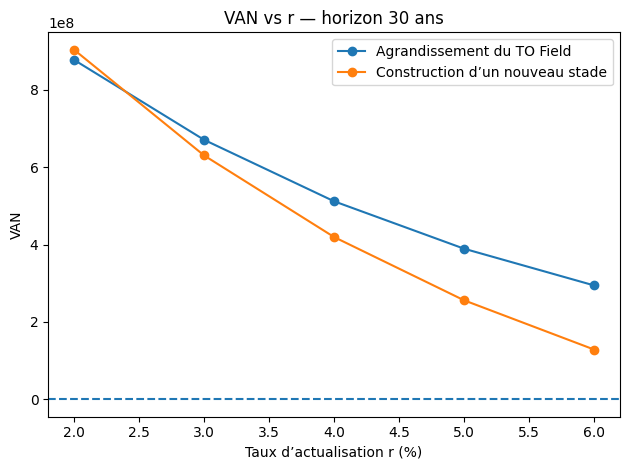

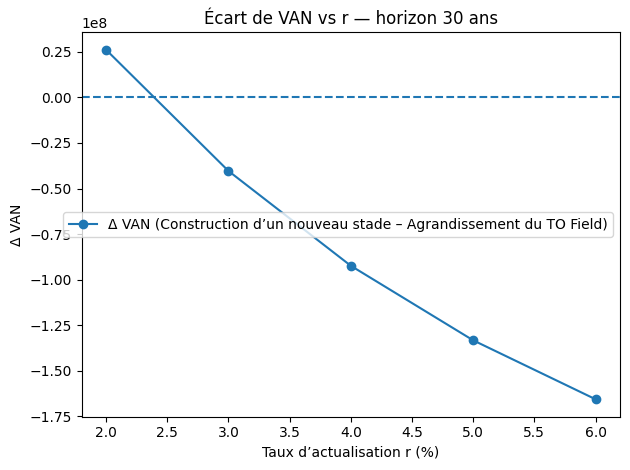

In [163]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# ---------------- Param√®tres ----------------
r_list    = [0.02, 0.03, 0.04, 0.05, 0.06]   # taux d'actualisation test√©s
horizons  = [10, 20, 30, 40]                 # horizons test√©s
proj_new  = "Construction d‚Äôun nouveau stade"
proj_ext  = "Agrandissement du TO Field"
horizon_plot = 30                             # horizon utilis√© pour les 2 graphiques
# --------------------------------------------

# --- Constants & param√®tres de croissance (d√©j√† utilis√©s plus t√¥t) ---
try:
    from utils.constants import VUEDENSEMBLE as PARAMS
except ImportError:
    from constants import vue_d_ensemble as PARAMS

gc = PARAMS["taux_croissance_couts"]      # croissance co√ªts
gr = PARAMS["taux_croissance_revenus"]    # croissance revenus

# Colonnes (conformes √† tes feuilles Excel)
col_uniques = [
    "Co√ªt d‚Äôachat du terrain",
    "Co√ªts de permis et d‚Äôinspection du site",
    "Co√ªts de pr√©paration du site",
]
col_annuels = [
    "Co√ªts annuels d‚Äôentretien",
    "Co√ªts annuels de location d‚Äô√©quipement",
]
col_mensuels = [
    "Co√ªts mensuels de fournitures et mat√©riaux",
    "Co√ªts mensuels des services publics",
    "Part mensuelle des revenus partag√©s avec les sponsors",
]
colonnes_revenus_cat = [
    "Revenus annuels de la billetterie ($)",
    "Revenus annuels de sponsoring ($)",
    "Revenus annuels des concessions ($)",
    "Ventes annuelles de marchandises ($)",
]

# --- Helpers (autonomes) ---
def projeter_construction(df_construction_src: pd.DataFrame, N: int) -> pd.DataFrame:
    idx = df_construction_src["Option de projet d‚Äôinfrastructure"].values
    out = pd.DataFrame(index=idx)
    out["Ann√©e 0"] = df_construction_src[col_uniques].sum(axis=1).astype(float).values
    for t in range(1, N + 1):
        facteur = (1 + gc) ** (t - 1)
        a = df_construction_src[col_annuels].sum(axis=1).astype(float).values * facteur
        m = df_construction_src[col_mensuels].sum(axis=1).astype(float).values * 12 * facteur
        out[f"Ann√©e {t}"] = a + m
    return out.astype(float)

def projeter_main_oeuvre(df_main_src: pd.DataFrame, N: int) -> pd.DataFrame:
    if "Salaire annuel (ann√©e 1)" not in df_main_src.columns:
        raise ValueError("df_main doit contenir 'Salaire annuel (ann√©e 1)'.")
    base = df_main_src[["Option de projet d‚Äôinfrastructure", "Salaire annuel (ann√©e 1)"]].copy()
    for t in range(2, N + 1):
        base[f"Salaire annuel (ann√©e {t})"] = base["Salaire annuel (ann√©e 1)"] * (1 + gc) ** (t - 1)
    agg = base.groupby("Option de projet d‚Äôinfrastructure").sum(numeric_only=True)
    agg.insert(0, "Ann√©e 0", 0.0)
    ren = {"Salaire annuel (ann√©e 1)": "Ann√©e 1"} | {f"Salaire annuel (ann√©e {t})": f"Ann√©e {t}" for t in range(2, N + 1)}
    agg = agg.rename(columns=ren)
    for t in range(0, N + 1):
        col = f"Ann√©e {t}"
        if col not in agg.columns: agg[col] = 0.0
    return agg[[f"Ann√©e {t}" for t in range(0, N + 1)]].astype(float)

def projeter_revenus(df_revenus_src: pd.DataFrame, N: int) -> pd.DataFrame:
    idx = df_revenus_src["Option de projet d‚Äôinfrastructure"].values
    out = pd.DataFrame(index=idx, columns=[f"Ann√©e {t}" for t in range(0, N + 1)], dtype=float).fillna(0.0)
    for _, row in df_revenus_src.iterrows():
        p = row["Option de projet d‚Äôinfrastructure"]
        for t in range(1, N + 1):
            total_t = sum(float(row[c]) * (1 + gr) ** (t - 1) for c in colonnes_revenus_cat)
            out.loc[p, f"Ann√©e {t}"] = total_t
    return out.astype(float)

def calculer_cf_et_van_avec_r(df_construction_src, df_main_src, df_revenus_src, N: int, r: float):
    cons = projeter_construction(df_construction_src, N)
    mo   = projeter_main_oeuvre(df_main_src, N)
    rev  = projeter_revenus(df_revenus_src, N)
    projets = sorted(set(cons.index) | set(mo.index) | set(rev.index))
    cf = pd.DataFrame(index=projets, columns=[f"Ann√©e {t}" for t in range(0, N + 1)], dtype=float)
    for p in projets:
        for t in range(0, N + 1):
            rv = rev.loc[p, f"Ann√©e {t}"] if p in rev.index else 0.0
            mm = mo.loc[p, f"Ann√©e {t}"] if p in mo.index else 0.0
            cc = cons.loc[p, f"Ann√©e {t}"] if p in cons.index else 0.0
            cf.loc[p, f"Ann√©e {t}"] = rv - (mm + cc)
    facteurs = np.array([(1 + r) ** t for t in range(0, N + 1)])
    van_vals = (cf.values / facteurs).sum(axis=1)
    df_van_N = pd.DataFrame({f"VAN ({N} ans, r = {r:.2%})": van_vals}, index=cf.index)
    return cf, df_van_N

# --- Boucle multi-r & multi-horizons ---
rows = []
for N in horizons:
    for r in r_list:
        _, vanN = calculer_cf_et_van_avec_r(df_construction, df_main, df_revenus, N, r)
        rows.append({
            "Horizon (ans)": N,
            "r": r,
            f"VAN {proj_ext}": float(vanN.loc[proj_ext].values[0]),
            f"VAN {proj_new}": float(vanN.loc[proj_new].values[0]),
        })
df_sens_r = pd.DataFrame(rows)

# --- Tables lisibles ---
def fmt_spaces(x):
    try: return f"{x:,.2f}".replace(",", " ")
    except: return x

tab_ext = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_ext}").applymap(fmt_spaces)
tab_new = df_sens_r.pivot(index="r", columns="Horizon (ans)", values=f"VAN {proj_new}").applymap(fmt_spaces)

print("VAN ‚Äî AGRANDISSEMENT (par r et horizon) :")
display(tab_ext)
print("\nVAN ‚Äî NOUVEAU STADE (par r et horizon) :")
display(tab_new)

# --- Graphiques (horizon choisi) ---
sub = df_sens_r[df_sens_r["Horizon (ans)"] == horizon_plot].sort_values("r")

plt.figure()
plt.plot(sub["r"]*100, sub[f"VAN {proj_ext}"], marker="o", label=proj_ext)
plt.plot(sub["r"]*100, sub[f"VAN {proj_new}"], marker="o", label=proj_new)
plt.axhline(0, linestyle="--")
plt.xlabel("Taux d‚Äôactualisation r (%)")
plt.ylabel("VAN")
plt.title(f"VAN vs r ‚Äî horizon {horizon_plot} ans")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
delta = sub[f"VAN {proj_new}"] - sub[f"VAN {proj_ext}"]
plt.plot(sub["r"]*100, delta, marker="o", label=f"Œî VAN ({proj_new} ‚Äì {proj_ext})")
plt.axhline(0, linestyle="--")
plt.xlabel("Taux d‚Äôactualisation r (%)")
plt.ylabel("Œî VAN")
plt.title(f"√âcart de VAN vs r ‚Äî horizon {horizon_plot} ans")
plt.legend()
plt.tight_layout()
plt.show()


## üìí Conclusion 9.3 ‚Äî Sensibilit√© au taux d‚Äôactualisation

* **Effet g√©n√©ral :** quand le **taux d‚Äôactualisation (r)** augmente, la **VAN** diminue pour les deux projets. L‚Äôeffet est **plus fort pour le nouveau stade**, car une plus grande part de sa valeur arrive tard (flux plus ‚Äúback-loaded‚Äù).
* **10 ans :** VAN < 0 pour les deux projets, quel que soit r.
* **20 ans :** l‚Äô**agrandissement** devient positif pour tous les r test√©s (de justesse √† 6 %) ; le **nouveau stade** reste n√©gatif pour tous les r.
* **30 ans :** les **deux** sont positifs. Le **nouveau stade** n‚Äôest **meilleur** que pour un **r tr√®s faible (~2‚Äì2,5 %)** ; d√®s **r ‚â• ~3 %**, l‚Äô**agrandissement** repasse devant.
* **40 ans :** le **nouveau stade** est **sup√©rieur** √† l‚Äôagrandissement **pour tous les r** test√©s.

**Lecture pour l‚Äôentretien :**

* √Ä **horizon ‚â§ 30 ans** et **r ‚Äúr√©aliste‚Äù (‚â•3 %) ‚Üí agrandissement**.
* √Ä **tr√®s long terme (‚âà40 ans)** ou avec un **r tr√®s bas (~2‚Äì2,5 %) ‚Üí nouveau stade**.